# Neural Networks with PyTorch: A Hands-On Lecture

**Duration:** 3 hours  
**Goal:** Build deep intuition for neural networks, backpropagation, and PyTorch training

## Learning Objectives

By the end of this lecture, you will:
- Understand how perceptrons evolve into neural networks
- Master the backpropagation algorithm (both intuition and implementation)
- Write a proper PyTorch training loop from scratch
- Compare optimization algorithms (SGD, Momentum, RMSProp, and Adam)
- Apply regularization techniques (Dropout)
- Debug networks by inspecting weights and gradients
- Build intuition for when to use different activation functions and optimizers


In [25]:
# Step 1: Install required packages
# Note: Run this cell first to ensure all dependencies are installed
%pip install torch matplotlib numpy scikit-learn seaborn -q


You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [26]:
# Import PyTorch and neural network modules
import torch
import torch.nn as nn  # Neural network layers and modules
import torch.optim as optim  # Optimizers (SGD, Adam, RMSProp, etc.)

# Import data science and visualization libraries
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification, make_moons
from sklearn.model_selection import train_test_split
import seaborn as sns

# Set random seeds for reproducibility (ensures consistent results across runs)
torch.manual_seed(42)
np.random.seed(42)

# Set matplotlib style for better-looking plots
try:
    plt.style.use('seaborn-v0_8-darkgrid')
except:
    try:
        plt.style.use('seaborn-darkgrid')
    except:
        plt.style.use('default')
sns.set_palette("husl")

# Display environment information
print("=" * 50)
print("Environment Setup")
print("=" * 50)
print(f"PyTorch version: {torch.__version__}")
print(f"Device: {'CUDA' if torch.cuda.is_available() else 'CPU'}")
print("=" * 50)
print("✅ All libraries imported successfully!")
print("Ready to start the lecture!")


Environment Setup
PyTorch version: 2.8.0
Device: CPU
✅ All libraries imported successfully!
Ready to start the lecture!


---

## Part 1: From Perceptron to Neural Networks

### The Perceptron: The Building Block

A **perceptron** is the simplest neural network unit:
- Takes inputs: $x_1, x_2, ..., x_n$
- Multiplies by weights: $w_1, w_2, ..., w_n$
- Adds bias: $b$
- Applies activation: $f(z)$ where $z = \sum_{i} w_i x_i + b$

**Output:** $y = f(\sum_{i} w_i x_i + b)$

Let's build one from scratch to understand the mechanics!


In [27]:
class Perceptron:
    """
    A simple perceptron implementation from scratch.
    
    This demonstrates the basic building block of neural networks:
    - Takes inputs, multiplies by weights, adds bias
    - Applies step activation function
    - Updates weights based on error
    """
    
    def __init__(self, n_features, learning_rate=0.01):
        """
        Initialize perceptron with random weights and bias.
        
        Args:
            n_features: Number of input features
            learning_rate: Step size for weight updates
        """
        # Initialize weights randomly (small values for stability)
        self.weights = torch.randn(n_features, requires_grad=False) * 0.1
        self.bias = torch.tensor(0.0, requires_grad=False)
        self.learning_rate = learning_rate
    
    def forward(self, x):
        """
        Forward pass: compute weighted sum + bias, then apply activation.
        
        Args:
            x: Input vector
        Returns:
            Output (0 or 1) after step activation
        """
        # Compute weighted sum: z = w1*x1 + w2*x2 + ... + b
        z = torch.dot(x, self.weights) + self.bias
        # Step activation: returns 1 if z > 0, else 0
        return torch.where(z > 0, torch.tensor(1.0), torch.tensor(0.0))
    
    def predict(self, X):
        """Predict for multiple samples"""
        return torch.tensor([self.forward(x) for x in X])
    
    def train_step(self, x, y_true):
        """
        One training step using perceptron learning rule.
        
        Perceptron learning rule:
        - If prediction is wrong, update weights: w = w + lr * error * x
        - If prediction is correct, don't update
        
        Args:
            x: Input vector
            y_true: True label
        Returns:
            Error value
        """
        y_pred = self.forward(x)
        error = y_true - y_pred
        
        # Perceptron learning rule: update only if error != 0
        if error != 0:
            self.weights += self.learning_rate * error * x
            self.bias += self.learning_rate * error
        
        return error.item()

# ===== DEMONSTRATION: Can a perceptron learn the AND gate? =====
# AND gate: Output is 1 only when BOTH inputs are 1
X_simple = torch.tensor([[0, 0], [0, 1], [1, 0], [1, 1]], dtype=torch.float32)
y_simple = torch.tensor([0, 0, 0, 1], dtype=torch.float32)  # AND gate truth table

# Create and train perceptron
perceptron = Perceptron(n_features=2, learning_rate=0.1)

print("Training perceptron on AND gate...")
print("=" * 50)
for epoch in range(20):
    total_error = 0
    for x, y in zip(X_simple, y_simple):
        error = perceptron.train_step(x, y)
        total_error += abs(error)
    
    if epoch % 5 == 0:
        print(f"Epoch {epoch}: Total error = {total_error:.2f}")

# Test the trained perceptron
print("\n" + "=" * 50)
print("Testing trained perceptron:")
print("=" * 50)
for x, y_true in zip(X_simple, y_simple):
    y_pred = perceptron.forward(x)
    status = "✓" if y_pred == y_true else "✗"
    print(f"{status} Input: {x.tolist()} -> Predicted: {y_pred:.0f}, True: {y_true:.0f}")

print("\n💡 Key Insight: A single perceptron CAN learn linearly separable problems like AND!")


Training perceptron on AND gate...
Epoch 0: Total error = 2.00
Epoch 5: Total error = 2.00
Epoch 10: Total error = 0.00
Epoch 15: Total error = 0.00

Testing trained perceptron:
✓ Input: [0.0, 0.0] -> Predicted: 0, True: 0
✓ Input: [0.0, 1.0] -> Predicted: 0, True: 0
✓ Input: [1.0, 0.0] -> Predicted: 0, True: 0
✓ Input: [1.0, 1.0] -> Predicted: 1, True: 1

💡 Key Insight: A single perceptron CAN learn linearly separable problems like AND!


### Why Single Perceptrons Fail: The XOR Problem

A single perceptron can only learn **linearly separable** problems. The XOR problem requires a **non-linear decision boundary**.

**Solution:** Stack multiple perceptrons → **Neural Network!**

A neural network is essentially:
- Multiple layers of perceptrons
- Each layer transforms the input
- Non-linear activations enable complex decision boundaries


/var/folders/b4/580wvvsn6p3gd7mh3mx84l5m0000gn/T/ipykernel_14582/4121275522.py:31: UserWarning: Glyph 8321 (\N{SUBSCRIPT ONE}) missing from font(s) Arial.
  plt.tight_layout()
/var/folders/b4/580wvvsn6p3gd7mh3mx84l5m0000gn/T/ipykernel_14582/4121275522.py:31: UserWarning: Glyph 8322 (\N{SUBSCRIPT TWO}) missing from font(s) Arial.
  plt.tight_layout()
/Users/varunraste/Library/Python/3.9/lib/python/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 8322 (\N{SUBSCRIPT TWO}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/varunraste/Library/Python/3.9/lib/python/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 8321 (\N{SUBSCRIPT ONE}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


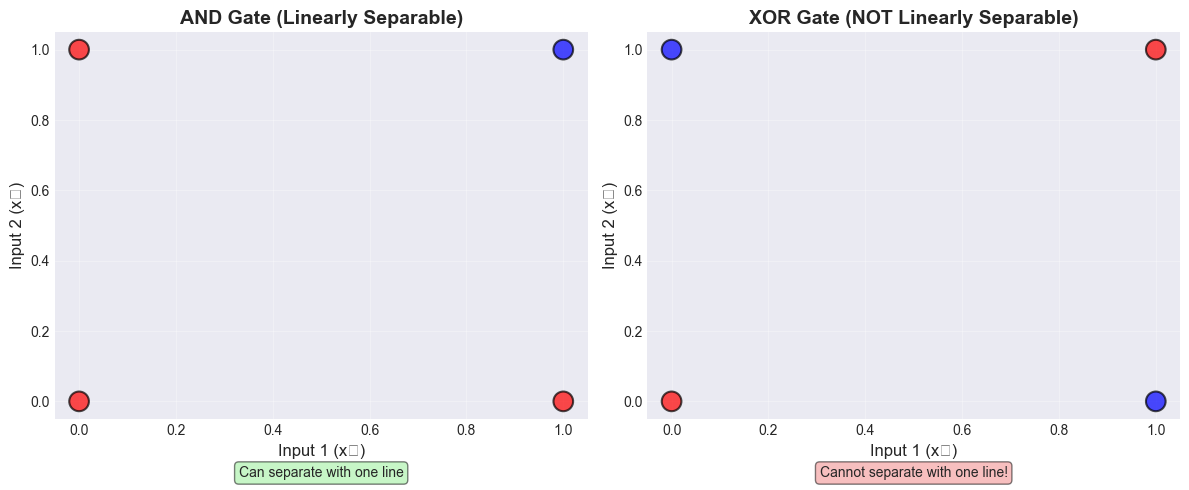


Key Observation:
• AND gate: Red and blue points can be separated by a SINGLE line
  → A single perceptron CAN solve this!

• XOR gate: Red and blue points are interleaved
  → A single perceptron CANNOT solve this!

💡 Solution: We need MULTIPLE perceptrons (neural network) with hidden layers
   to create non-linear decision boundaries!


In [28]:
# Visualize the difference between AND and XOR problems
X_xor = torch.tensor([[0, 0], [0, 1], [1, 0], [1, 1]], dtype=torch.float32)
y_xor = torch.tensor([0, 1, 1, 0], dtype=torch.float32)  # XOR: output 1 when inputs differ

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# AND gate (linearly separable - can be separated by a single line)
colors_and = ['red' if y == 0 else 'blue' for y in y_simple]
axes[0].scatter(X_simple[:, 0], X_simple[:, 1], c=colors_and, s=200, alpha=0.7, 
                edgecolors='black', linewidths=1.5)
axes[0].set_title('AND Gate (Linearly Separable)', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Input 1 (x₁)', fontsize=12)
axes[0].set_ylabel('Input 2 (x₂)', fontsize=12)
axes[0].grid(True, alpha=0.3)
axes[0].text(0.5, -0.15, 'Can separate with one line', 
            transform=axes[0].transAxes, ha='center', fontsize=10, 
            bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.5))

# XOR gate (NOT linearly separable - requires non-linear boundary)
colors_xor = ['red' if y == 0 else 'blue' for y in y_xor]
axes[1].scatter(X_xor[:, 0], X_xor[:, 1], c=colors_xor, s=200, alpha=0.7,
                edgecolors='black', linewidths=1.5)
axes[1].set_title('XOR Gate (NOT Linearly Separable)', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Input 1 (x₁)', fontsize=12)
axes[1].set_ylabel('Input 2 (x₂)', fontsize=12)
axes[1].grid(True, alpha=0.3)
axes[1].text(0.5, -0.15, 'Cannot separate with one line!', 
            transform=axes[1].transAxes, ha='center', fontsize=10,
            bbox=dict(boxstyle='round', facecolor='lightcoral', alpha=0.5))

plt.tight_layout()
plt.show()

print("\n" + "=" * 60)
print("Key Observation:")
print("=" * 60)
print("• AND gate: Red and blue points can be separated by a SINGLE line")
print("  → A single perceptron CAN solve this!")
print("\n• XOR gate: Red and blue points are interleaved")
print("  → A single perceptron CANNOT solve this!")
print("\n💡 Solution: We need MULTIPLE perceptrons (neural network) with hidden layers")
print("   to create non-linear decision boundaries!")
print("=" * 60)


---

## Part 2: Activation Functions

Activation functions introduce **non-linearity** into neural networks. Without them, multiple layers would collapse into a single linear transformation.

**Why non-linearity matters:** 
- A network with only linear activations is equivalent to a single linear layer
- Non-linearity enables the network to learn complex, non-linear patterns
- Different activations have different properties and use cases

### 1. ReLU (Rectified Linear Unit) - Most Popular

**Formula:** $f(x) = \max(0, x)$

**Properties:**
- **Most common** activation in modern deep learning
- **Simple and fast**: Just a threshold at zero
- **Sparsity**: Produces zero for negative inputs (can be beneficial)
- **Helps with vanishing gradients**: Gradient is either 0 or 1 (no saturation for positive values)

**Problems:**
- **"Dying ReLU"**: Neurons can become permanently inactive if they always output 0
- **Not zero-centered**: Outputs are always ≥ 0
- **Gradient is zero** for negative inputs (can cause dead neurons)

**When to use:** Default choice for hidden layers in most modern architectures

### 2. Tanh (Hyperbolic Tangent) - Zero-Centered Alternative

**Formula:** $f(x) = \tanh(x) = \frac{e^x - e^{-x}}{e^x + e^{-x}}$

**Properties:**
- **Output range**: $(-1, 1)$ (bounded)
- **Zero-centered**: Mean output is 0 (better for optimization)
- **Smooth**: Continuous and differentiable everywhere
- **Symmetric**: $f(-x) = -f(x)$

**Problems:**
- **Vanishing gradients**: For extreme values, gradient approaches 0
- **Saturation**: Outputs saturate at -1 and 1 for large inputs

**When to use:** RNNs, when you need bounded outputs, zero-centered activations

### 3. Sigmoid - Classic Choice

**Formula:** $f(x) = \frac{1}{1 + e^{-x}} = \sigma(x)$

**Properties:**
- **Output range**: $(0, 1)$ (bounded)
- **Smooth**: Continuous and differentiable
- **Interpretable**: Output can be interpreted as probability

**Problems:**
- **Not zero-centered**: Outputs are always > 0
- **Vanishing gradients**: Very small gradients for extreme values
- **Saturation**: Outputs saturate at 0 and 1

**When to use:** Output layer for binary classification (with appropriate loss function), but rarely in hidden layers

Let's visualize all three and understand their differences!


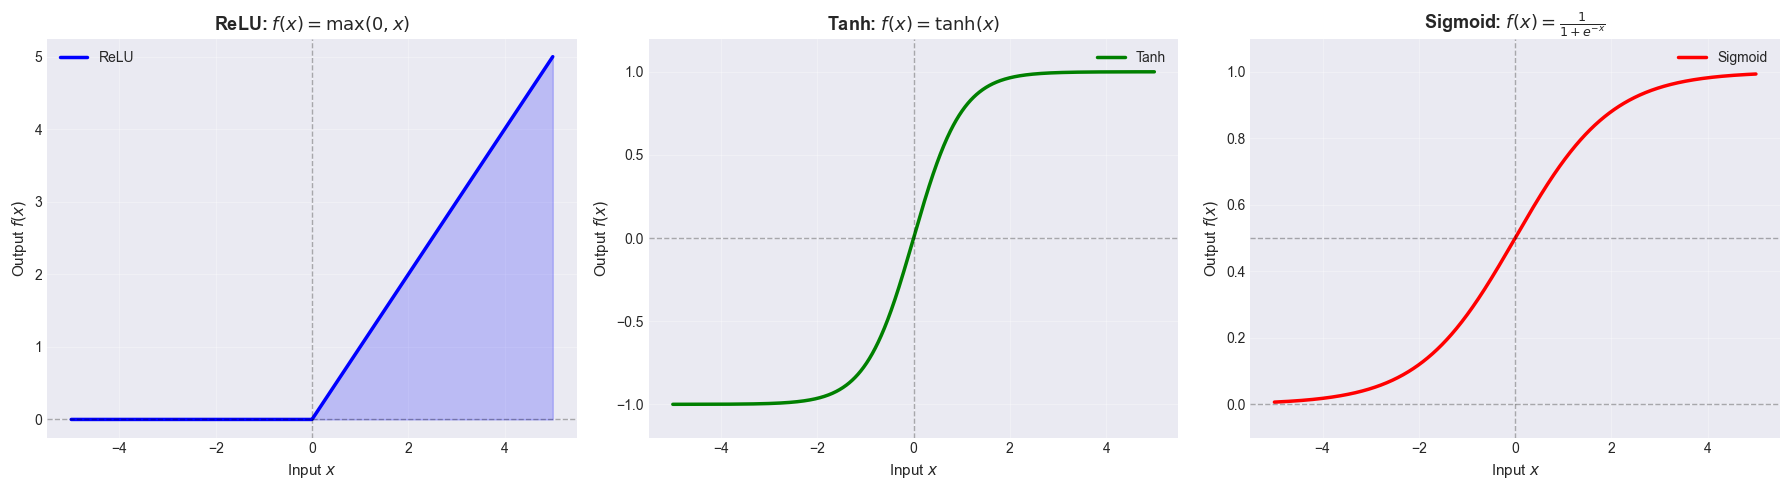

/var/folders/b4/580wvvsn6p3gd7mh3mx84l5m0000gn/T/ipykernel_14582/1896466201.py:103: UserWarning: Glyph 9888 (\N{WARNING SIGN}) missing from font(s) Arial.
  plt.tight_layout()
/var/folders/b4/580wvvsn6p3gd7mh3mx84l5m0000gn/T/ipykernel_14582/1896466201.py:103: UserWarning: Glyph 65039 (\N{VARIATION SELECTOR-16}) missing from font(s) Arial.
  plt.tight_layout()
/Users/varunraste/Library/Python/3.9/lib/python/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 9888 (\N{WARNING SIGN}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/varunraste/Library/Python/3.9/lib/python/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 65039 (\N{VARIATION SELECTOR-16}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


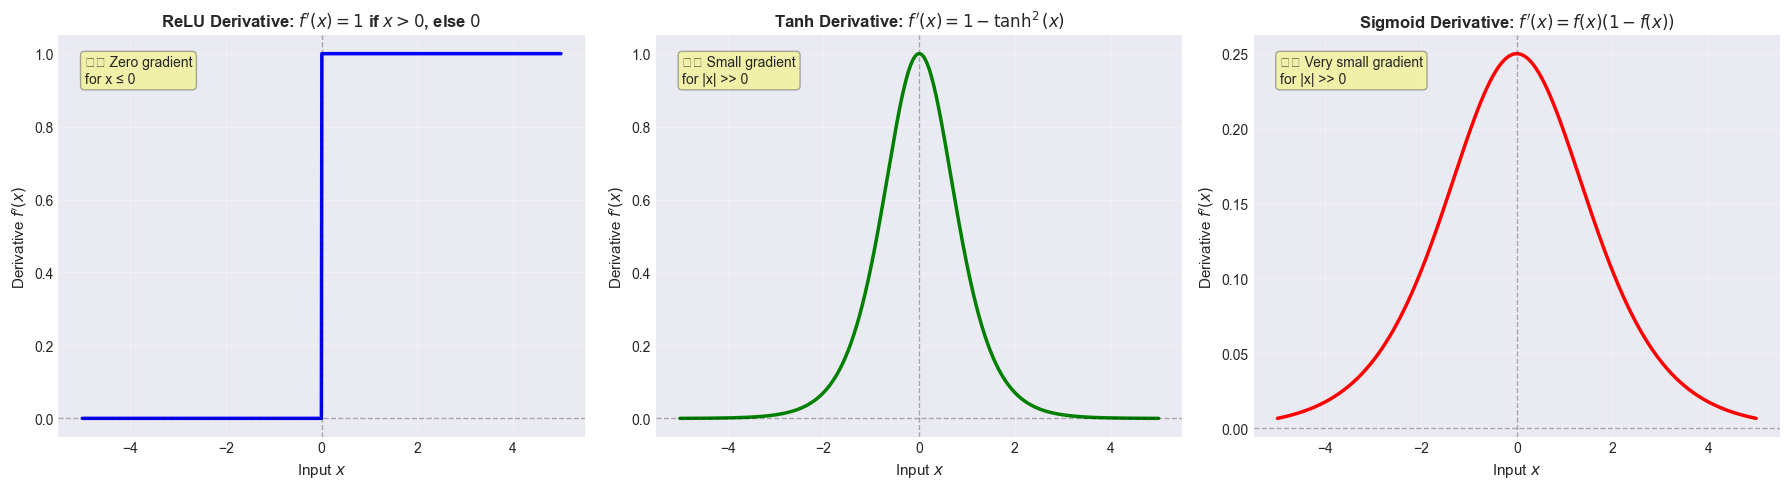


=== Key Insights ===
1. ReLU:
   • Derivative is 0 for negative inputs → can cause 'dying ReLU' problem
   • Derivative is 1 for positive inputs → no gradient vanishing for active neurons
   • Most popular choice for hidden layers in modern networks

2. Tanh:
   • Smooth derivative, but can be very small for extreme values → vanishing gradients
   • Zero-centered → better for optimization than sigmoid
   • Good for RNNs and when you need bounded outputs

3. Sigmoid:
   • Very small gradients for extreme values → severe vanishing gradient problem
   • Not zero-centered → can slow down training
   • Mainly used in output layer for binary classification

💡 Practical tip: ReLU is the default choice, but experiment with others for your specific problem!


In [29]:
# Visualize activation functions and their derivatives
x = torch.linspace(-5, 5, 1000)

relu = torch.relu(x)
tanh = torch.tanh(x)
sigmoid = torch.sigmoid(x)

# Convert to numpy for plotting
x_np = x.detach().numpy()
relu_np = relu.detach().numpy()
tanh_np = tanh.detach().numpy()
sigmoid_np = sigmoid.detach().numpy()

# Plot activations
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

axes[0].plot(x_np, relu_np, 'b-', linewidth=2.5, label='ReLU')
axes[0].axhline(y=0, color='k', linestyle='--', alpha=0.3, linewidth=1)
axes[0].axvline(x=0, color='k', linestyle='--', alpha=0.3, linewidth=1)
axes[0].set_title('ReLU: $f(x) = \\max(0, x)$', fontsize=13, fontweight='bold')
axes[0].set_xlabel('Input $x$', fontsize=11)
axes[0].set_ylabel('Output $f(x)$', fontsize=11)
axes[0].grid(True, alpha=0.3)
axes[0].legend(fontsize=10)
axes[0].fill_between(x_np, 0, relu_np, alpha=0.2, color='blue')

axes[1].plot(x_np, tanh_np, 'g-', linewidth=2.5, label='Tanh')
axes[1].axhline(y=0, color='k', linestyle='--', alpha=0.3, linewidth=1)
axes[1].axvline(x=0, color='k', linestyle='--', alpha=0.3, linewidth=1)
axes[1].set_title('Tanh: $f(x) = \\tanh(x)$', fontsize=13, fontweight='bold')
axes[1].set_xlabel('Input $x$', fontsize=11)
axes[1].set_ylabel('Output $f(x)$', fontsize=11)
axes[1].grid(True, alpha=0.3)
axes[1].legend(fontsize=10)
axes[1].set_ylim(-1.2, 1.2)

axes[2].plot(x_np, sigmoid_np, 'r-', linewidth=2.5, label='Sigmoid')
axes[2].axhline(y=0, color='k', linestyle='--', alpha=0.3, linewidth=1)
axes[2].axhline(y=0.5, color='k', linestyle='--', alpha=0.3, linewidth=1)
axes[2].axvline(x=0, color='k', linestyle='--', alpha=0.3, linewidth=1)
axes[2].set_title('Sigmoid: $f(x) = \\frac{1}{1+e^{-x}}$', fontsize=13, fontweight='bold')
axes[2].set_xlabel('Input $x$', fontsize=11)
axes[2].set_ylabel('Output $f(x)$', fontsize=11)
axes[2].grid(True, alpha=0.3)
axes[2].legend(fontsize=10)
axes[2].set_ylim(-0.1, 1.1)

plt.tight_layout()
plt.show()

# Compute derivatives
# ReLU derivative: 1 if x > 0, else 0
relu_derivative = (x > 0).float()

# Tanh derivative: 1 - tanh²(x)
tanh_derivative = 1 - tanh**2

# Sigmoid derivative: sigmoid(x) * (1 - sigmoid(x))
sigmoid_derivative = sigmoid * (1 - sigmoid)

# Convert to numpy
relu_deriv_np = relu_derivative.detach().numpy()
tanh_deriv_np = tanh_derivative.detach().numpy()
sigmoid_deriv_np = sigmoid_derivative.detach().numpy()

# Plot derivatives
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

axes[0].plot(x_np, relu_deriv_np, 'b-', linewidth=2.5)
axes[0].axhline(y=0, color='k', linestyle='--', alpha=0.3, linewidth=1)
axes[0].axvline(x=0, color='k', linestyle='--', alpha=0.3, linewidth=1)
axes[0].set_title("ReLU Derivative: $f'(x) = 1$ if $x > 0$, else $0$", 
                  fontsize=12, fontweight='bold')
axes[0].set_xlabel('Input $x$', fontsize=11)
axes[0].set_ylabel("Derivative $f'(x)$", fontsize=11)
axes[0].grid(True, alpha=0.3)
axes[0].text(0.05, 0.95, '⚠️ Zero gradient\nfor x ≤ 0', 
            transform=axes[0].transAxes, fontsize=10, 
            verticalalignment='top', bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.3))

axes[1].plot(x_np, tanh_deriv_np, 'g-', linewidth=2.5)
axes[1].axhline(y=0, color='k', linestyle='--', alpha=0.3, linewidth=1)
axes[1].axvline(x=0, color='k', linestyle='--', alpha=0.3, linewidth=1)
axes[1].set_title("Tanh Derivative: $f'(x) = 1 - \\tanh^2(x)$", fontsize=12, fontweight='bold')
axes[1].set_xlabel('Input $x$', fontsize=11)
axes[1].set_ylabel("Derivative $f'(x)$", fontsize=11)
axes[1].grid(True, alpha=0.3)
axes[1].text(0.05, 0.95, '⚠️ Small gradient\nfor |x| >> 0', 
            transform=axes[1].transAxes, fontsize=10, 
            verticalalignment='top', bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.3))

axes[2].plot(x_np, sigmoid_deriv_np, 'r-', linewidth=2.5)
axes[2].axhline(y=0, color='k', linestyle='--', alpha=0.3, linewidth=1)
axes[2].axvline(x=0, color='k', linestyle='--', alpha=0.3, linewidth=1)
axes[2].set_title("Sigmoid Derivative: $f'(x) = f(x)(1-f(x))$", fontsize=12, fontweight='bold')
axes[2].set_xlabel('Input $x$', fontsize=11)
axes[2].set_ylabel("Derivative $f'(x)$", fontsize=11)
axes[2].grid(True, alpha=0.3)
axes[2].text(0.05, 0.95, '⚠️ Very small gradient\nfor |x| >> 0', 
            transform=axes[2].transAxes, fontsize=10, 
            verticalalignment='top', bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.3))

plt.tight_layout()
plt.show()

print("\n=== Key Insights ===")
print("1. ReLU:")
print("   • Derivative is 0 for negative inputs → can cause 'dying ReLU' problem")
print("   • Derivative is 1 for positive inputs → no gradient vanishing for active neurons")
print("   • Most popular choice for hidden layers in modern networks")
print("\n2. Tanh:")
print("   • Smooth derivative, but can be very small for extreme values → vanishing gradients")
print("   • Zero-centered → better for optimization than sigmoid")
print("   • Good for RNNs and when you need bounded outputs")
print("\n3. Sigmoid:")
print("   • Very small gradients for extreme values → severe vanishing gradient problem")
print("   • Not zero-centered → can slow down training")
print("   • Mainly used in output layer for binary classification")
print("\n💡 Practical tip: ReLU is the default choice, but experiment with others for your specific problem!")


---

## Part 3: Backpropagation - The Heart of Neural Networks

### Intuition: How Neural Networks Learn

**Forward Pass:**
1. Input flows through layers
2. Each layer computes: $z = Wx + b$, then $a = f(z)$
3. Final output is compared to target → **loss**

**Backward Pass (Backpropagation):**
1. Compute gradient of loss w.r.t. output
2. Propagate gradients backward through layers
3. Update weights: $w_{new} = w_{old} - \alpha \frac{\partial L}{\partial w}$

### The Chain Rule

Backpropagation is essentially the **chain rule** of calculus applied repeatedly:

If $L = f(g(h(x)))$, then:
$$\frac{\partial L}{\partial x} = \frac{\partial L}{\partial f} \cdot \frac{\partial f}{\partial g} \cdot \frac{\partial g}{\partial h} \cdot \frac{\partial h}{\partial x}$$

In neural networks, we compute gradients layer by layer, starting from the output.


In [30]:
# ===== MANUAL BACKPROPAGATION DEMONSTRATION =====
# Let's build a simple network manually to see how gradients flow
# Network architecture: Input -> Linear -> ReLU -> Linear -> Output

# Input: a single sample with 2 features
x = torch.tensor([[2.0, 3.0]], requires_grad=False)
print("=" * 60)
print("Forward Pass:")
print("=" * 60)
print(f"Input x: {x}")

# ===== LAYER 1: Linear Transformation =====
# Weights and bias for first layer (2 inputs -> 2 outputs)
W1 = torch.tensor([[0.5, 0.3], [0.2, 0.4]], requires_grad=True)
b1 = torch.tensor([[0.1, 0.2]], requires_grad=True)
z1 = torch.matmul(x, W1) + b1  # z1 = x * W1 + b1
print(f"\nLayer 1 (Linear): z1 = x * W1 + b1")
print(f"  z1 = {z1}")

# ===== ACTIVATION: ReLU =====
a1 = torch.relu(z1)  # ReLU: max(0, z1)
print(f"\nActivation (ReLU): a1 = ReLU(z1)")
print(f"  a1 = {a1}")

# ===== LAYER 2: Linear Transformation =====
# Weights and bias for second layer (2 inputs -> 1 output)
W2 = torch.tensor([[0.6], [0.8]], requires_grad=True)
b2 = torch.tensor([[0.3]], requires_grad=True)
z2 = torch.matmul(a1, W2) + b2  # z2 = a1 * W2 + b2
print(f"\nLayer 2 (Linear): z2 = a1 * W2 + b2")
print(f"  Final output z2 = {z2}")

# ===== LOSS CALCULATION =====
target = torch.tensor([[1.0]])  # What we want the output to be
loss = (z2 - target) ** 2  # Mean Squared Error (simplified)
print(f"\nLoss Calculation:")
print(f"  Target: {target.item()}")
print(f"  Prediction: {z2.item():.4f}")
print(f"  Loss (MSE): {loss.item():.4f}")

# ===== BACKWARD PASS: Backpropagation =====
print("\n" + "=" * 60)
print("Backward Pass (Backpropagation):")
print("=" * 60)
loss.backward()  # This triggers automatic gradient computation!

print("\nGradients computed by PyTorch (via automatic differentiation):")
print(f"  dL/dW2 (gradient w.r.t. W2):\n{W2.grad}")
print(f"  dL/db2 (gradient w.r.t. b2):\n{b2.grad}")
print(f"  dL/dW1 (gradient w.r.t. W1):\n{W1.grad}")
print(f"  dL/db1 (gradient w.r.t. b1):\n{b1.grad}")

print("\n" + "=" * 60)
print("Understanding Gradients:")
print("=" * 60)
print("• Gradients tell us: 'How much does loss change if I change this weight?'")
print("• Positive gradient → Increasing weight increases loss (bad!)")
print("• Negative gradient → Increasing weight decreases loss (good!)")
print("• We update weights in OPPOSITE direction: w = w - lr * gradient")
print("• Learning rate (lr) controls how big a step we take")
print("\n💡 PyTorch's autograd does all this automatically with loss.backward()!")
print("=" * 60)


Forward Pass:
Input x: tensor([[2., 3.]])

Layer 1 (Linear): z1 = x * W1 + b1
  z1 = tensor([[1.7000, 2.0000]], grad_fn=<AddBackward0>)

Activation (ReLU): a1 = ReLU(z1)
  a1 = tensor([[1.7000, 2.0000]], grad_fn=<ReluBackward0>)

Layer 2 (Linear): z2 = a1 * W2 + b2
  Final output z2 = tensor([[2.9200]], grad_fn=<AddBackward0>)

Loss Calculation:
  Target: 1.0
  Prediction: 2.9200
  Loss (MSE): 3.6864

Backward Pass (Backpropagation):

Gradients computed by PyTorch (via automatic differentiation):
  dL/dW2 (gradient w.r.t. W2):
tensor([[6.5280],
        [7.6800]])
  dL/db2 (gradient w.r.t. b2):
tensor([[3.8400]])
  dL/dW1 (gradient w.r.t. W1):
tensor([[4.6080, 6.1440],
        [6.9120, 9.2160]])
  dL/db1 (gradient w.r.t. b1):
tensor([[2.3040, 3.0720]])

Understanding Gradients:
• Gradients tell us: 'How much does loss change if I change this weight?'
• Positive gradient → Increasing weight increases loss (bad!)
• Negative gradient → Increasing weight decreases loss (good!)
• We update w

Gradient Flow Visualization:


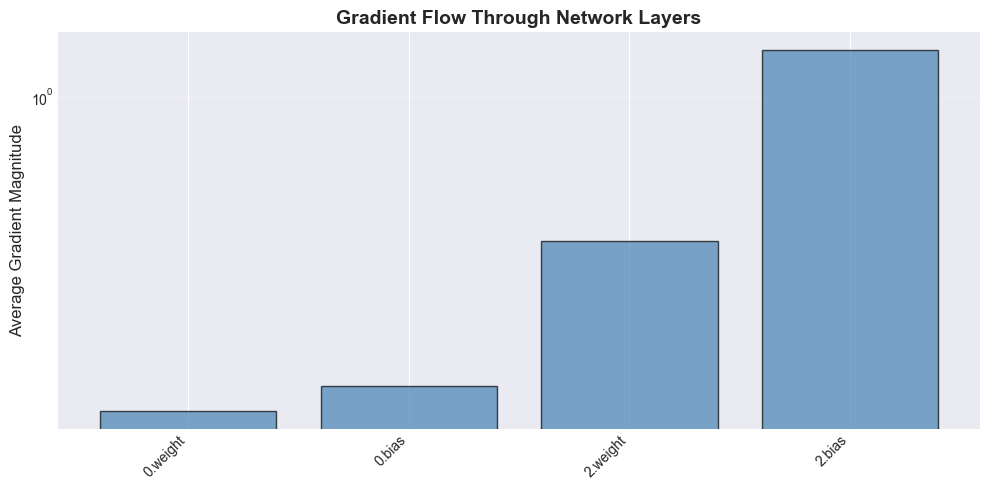


Gradient Magnitudes by Layer:
------------------------------------------------------------
  0.weight            : 0.132175
  0.bias              : 0.154635
  2.weight            : 0.395390
  2.bias              : 1.346563
------------------------------------------------------------

💡 Healthy gradients: Moderate values (not too small, not too large)
💡 Watch for: Very small gradients (vanishing) or very large (exploding)


In [31]:
# ===== VISUALIZE GRADIENT FLOW =====
# This function helps us see how gradients flow through different layers
def visualize_gradient_flow(model):
    """
    Plot gradient magnitudes across layers to visualize gradient flow.
    
    This helps detect:
    - Vanishing gradients: Very small gradients in early layers
    - Exploding gradients: Very large gradients
    - Healthy gradients: Moderate, stable values
    """
    gradients = []
    layer_names = []
    
    # Collect gradient magnitudes for each parameter
    for name, param in model.named_parameters():
        if param.grad is not None:
            # Average absolute gradient value for this layer
            gradients.append(param.grad.abs().mean().item())
            layer_names.append(name)
    
    # Plot gradient magnitudes
    plt.figure(figsize=(10, 5))
    bars = plt.bar(range(len(gradients)), gradients, alpha=0.7, color='steelblue', edgecolor='black')
    plt.xticks(range(len(layer_names)), layer_names, rotation=45, ha='right', fontsize=10)
    plt.ylabel('Average Gradient Magnitude', fontsize=12)
    plt.title('Gradient Flow Through Network Layers', fontsize=14, fontweight='bold')
    plt.yscale('log')  # Log scale to see small differences
    plt.grid(True, alpha=0.3, axis='y')
    plt.tight_layout()
    plt.show()
    
    return gradients, layer_names

# Create a simple model for demonstration
simple_model = nn.Sequential(
    nn.Linear(2, 4),   # Layer 1: 2 inputs -> 4 hidden
    nn.ReLU(),         # Activation
    nn.Linear(4, 1)    # Layer 2: 4 hidden -> 1 output
)

# Perform forward and backward pass to generate gradients
x_demo = torch.randn(1, 2)  # Random input
y_demo = torch.randn(1, 1)   # Random target

output = simple_model(x_demo)
loss = nn.MSELoss()(output, y_demo)
loss.backward()  # Compute gradients

print("=" * 60)
print("Gradient Flow Visualization:")
print("=" * 60)
gradients, names = visualize_gradient_flow(simple_model)

print("\nGradient Magnitudes by Layer:")
print("-" * 60)
for name, grad in zip(names, gradients):
    print(f"  {name:20s}: {grad:.6f}")
print("-" * 60)
print("\n💡 Healthy gradients: Moderate values (not too small, not too large)")
print("💡 Watch for: Very small gradients (vanishing) or very large (exploding)")
print("=" * 60)


---

## Part 4: Building a Complete Training Loop

Now we'll build a **proper PyTorch training loop** from scratch. This is the foundation of all deep learning!

### Key Components:
1. **Model definition** (using `nn.Module`)
2. **Loss function** (e.g., CrossEntropyLoss, MSELoss)
3. **Optimizer** (e.g., SGD, Adam)
4. **Training loop:**
   - Forward pass
   - Compute loss
   - Backward pass (compute gradients)
   - Update weights
5. **Validation loop** (evaluate on test set)


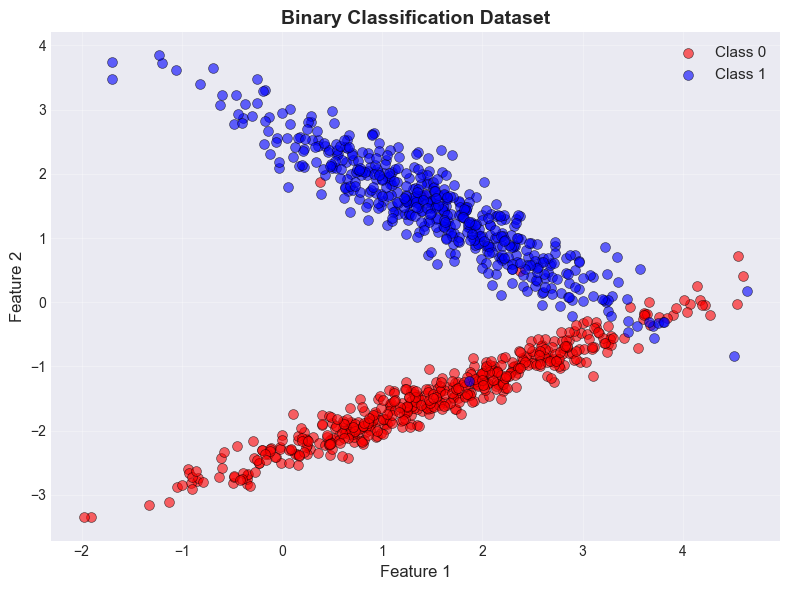

Dataset Information:
Total samples: 1000
Training samples: 800 (80%)
Test samples: 200 (20%)
Number of features: 2
Number of classes: 2


In [32]:
# ===== CREATE CLASSIFICATION DATASET =====
# Generate a synthetic 2D classification dataset
# This is a simple dataset perfect for learning neural networks
X, y = make_classification(n_samples=1000, n_features=2, n_redundant=0, 
                           n_informative=2, n_clusters_per_class=1, 
                           random_state=42, class_sep=1.5)

# Convert numpy arrays to PyTorch tensors
X_tensor = torch.FloatTensor(X)  # Features (inputs)
y_tensor = torch.LongTensor(y)   # Labels (targets)

# Split dataset into training and test sets
# 80% for training, 20% for testing
X_train, X_test, y_train, y_test = train_test_split(
    X_tensor, y_tensor, test_size=0.2, random_state=42
)

# Visualize the dataset
plt.figure(figsize=(8, 6))
plt.scatter(X[y==0, 0], X[y==0, 1], c='red', alpha=0.6, label='Class 0', s=50, edgecolors='black', linewidths=0.5)
plt.scatter(X[y==1, 0], X[y==1, 1], c='blue', alpha=0.6, label='Class 1', s=50, edgecolors='black', linewidths=0.5)
plt.xlabel('Feature 1', fontsize=12)
plt.ylabel('Feature 2', fontsize=12)
plt.title('Binary Classification Dataset', fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("=" * 60)
print("Dataset Information:")
print("=" * 60)
print(f"Total samples: {len(X_tensor)}")
print(f"Training samples: {len(X_train)} (80%)")
print(f"Test samples: {len(X_test)} (20%)")
print(f"Number of features: {X_tensor.shape[1]}")
print(f"Number of classes: {len(torch.unique(y_tensor))}")
print("=" * 60)


In [33]:
# ===== DEFINE NEURAL NETWORK ARCHITECTURE =====
class SimpleNN(nn.Module):
    """
    A simple 2-layer neural network for binary classification.
    
    Architecture:
    - Input layer: 2 features
    - Hidden layer: 10 neurons with ReLU activation
    - Output layer: 2 classes (for binary classification)
    """
    
    def __init__(self, input_size=2, hidden_size=10, output_size=2):
        """
        Initialize the neural network.
        
        Args:
            input_size: Number of input features (2 in our case)
            hidden_size: Number of neurons in hidden layer (10)
            output_size: Number of output classes (2 for binary classification)
        """
        super(SimpleNN, self).__init__()
        # Layer 1: Input -> Hidden (fully connected/linear layer)
        self.fc1 = nn.Linear(input_size, hidden_size)
        # Activation function: ReLU (adds non-linearity)
        self.relu = nn.ReLU()
        # Layer 2: Hidden -> Output (fully connected/linear layer)
        self.fc2 = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        """
        Forward pass: data flows through the network.
        
        Args:
            x: Input tensor of shape (batch_size, input_size)
        Returns:
            Output tensor of shape (batch_size, output_size)
        """
        out = self.fc1(x)      # Linear transformation: x -> hidden
        out = self.relu(out)   # Non-linear activation: adds non-linearity
        out = self.fc2(out)    # Final linear transformation: hidden -> output
        return out

# Create an instance of the model
model = SimpleNN(input_size=2, hidden_size=10, output_size=2)

print("=" * 60)
print("Neural Network Architecture:")
print("=" * 60)
print(model)
print("\n" + "-" * 60)
print("Model Details:")
print("-" * 60)
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total parameters: {total_params}")
print(f"Trainable parameters: {trainable_params}")
print(f"Architecture: {model.fc1.in_features} → {model.fc1.out_features} → {model.fc2.out_features}")
print("=" * 60)


Neural Network Architecture:
SimpleNN(
  (fc1): Linear(in_features=2, out_features=10, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=10, out_features=2, bias=True)
)

------------------------------------------------------------
Model Details:
------------------------------------------------------------
Total parameters: 52
Trainable parameters: 52
Architecture: 2 → 10 → 2


In [34]:
# ===== THE TRAINING LOOP - THE CORE OF DEEP LEARNING =====
# This is the fundamental pattern used in all deep learning!

def train_epoch(model, X_train, y_train, criterion, optimizer):
    """
    Train the model for one epoch (one pass through all training data).
    
    Args:
        model: Neural network model
        X_train: Training inputs
        y_train: Training labels
        criterion: Loss function
        optimizer: Optimizer for updating weights
    Returns:
        loss: Training loss for this epoch
        accuracy: Training accuracy for this epoch
    """
    model.train()  # Set to training mode (enables dropout, batch norm updates, etc.)
    
    # Step 1: Forward pass - make predictions
    outputs = model(X_train)
    loss = criterion(outputs, y_train)
    
    # Step 2: Backward pass - compute gradients
    optimizer.zero_grad()  # Clear previous gradients (CRITICAL: don't forget this!)
    loss.backward()       # Compute gradients via backpropagation
    optimizer.step()      # Update weights using gradients
    
    # Calculate accuracy
    _, predicted = torch.max(outputs.data, 1)  # Get predicted class
    accuracy = (predicted == y_train).float().mean()  # Calculate accuracy
    
    return loss.item(), accuracy.item()

def evaluate(model, X_test, y_test, criterion):
    """
    Evaluate the model on test set (no training, just prediction).
    
    Args:
        model: Neural network model
        X_test: Test inputs
        y_test: Test labels
        criterion: Loss function
    Returns:
        loss: Test loss
        accuracy: Test accuracy
    """
    model.eval()  # Set to evaluation mode (disables dropout, batch norm uses running stats)
    
    with torch.no_grad():  # Don't compute gradients (saves memory and time!)
        outputs = model(X_test)
        loss = criterion(outputs, y_test)
        _, predicted = torch.max(outputs.data, 1)
        accuracy = (predicted == y_test).float().mean()
    
    return loss.item(), accuracy.item()

# ===== TRAINING SETUP =====
# Loss function: Measures how wrong our predictions are
criterion = nn.CrossEntropyLoss()  # Good for multi-class classification

# Optimizer: Updates weights to minimize loss
optimizer = optim.SGD(model.parameters(), lr=0.01)  # Stochastic Gradient Descent

# Training configuration
num_epochs = 100
train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []

# ===== MAIN TRAINING LOOP =====
print("=" * 60)
print("Training Started")
print("=" * 60)
print(f"Training for {num_epochs} epochs...")
print("Watch how loss decreases and accuracy increases!\n")

for epoch in range(num_epochs):
    # Train for one epoch
    train_loss, train_acc = train_epoch(model, X_train, y_train, criterion, optimizer)
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    
    # Evaluate on test set
    test_loss, test_acc = evaluate(model, X_test, y_test, criterion)
    test_losses.append(test_loss)
    test_accuracies.append(test_acc)
    
    # Print progress every 20 epochs
    if (epoch + 1) % 20 == 0:
        print(f"Epoch [{epoch+1:3d}/{num_epochs}]")
        print(f"  Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")
        print(f"  Test Loss:  {test_loss:.4f}, Test Acc:  {test_acc:.4f}")
        print()

print("=" * 60)
print("Training Completed!")
print("=" * 60)
print(f"Final Test Accuracy: {test_accuracies[-1]:.2%}")
print(f"Final Test Loss: {test_losses[-1]:.4f}")
print("=" * 60)


Training Started
Training for 100 epochs...
Watch how loss decreases and accuracy increases!

Epoch [ 20/100]
  Train Loss: 0.6587, Train Acc: 0.5700
  Test Loss:  0.6409, Test Acc:  0.5900

Epoch [ 40/100]
  Train Loss: 0.5631, Train Acc: 0.9650
  Test Loss:  0.5588, Test Acc:  0.9750

Epoch [ 60/100]
  Train Loss: 0.5106, Train Acc: 0.9362
  Test Loss:  0.5126, Test Acc:  0.9250

Epoch [ 80/100]
  Train Loss: 0.4729, Train Acc: 0.9312
  Test Loss:  0.4786, Test Acc:  0.9200

Epoch [100/100]
  Train Loss: 0.4422, Train Acc: 0.9388
  Test Loss:  0.4502, Test Acc:  0.9350

Training Completed!
Final Test Accuracy: 93.50%
Final Test Loss: 0.4502


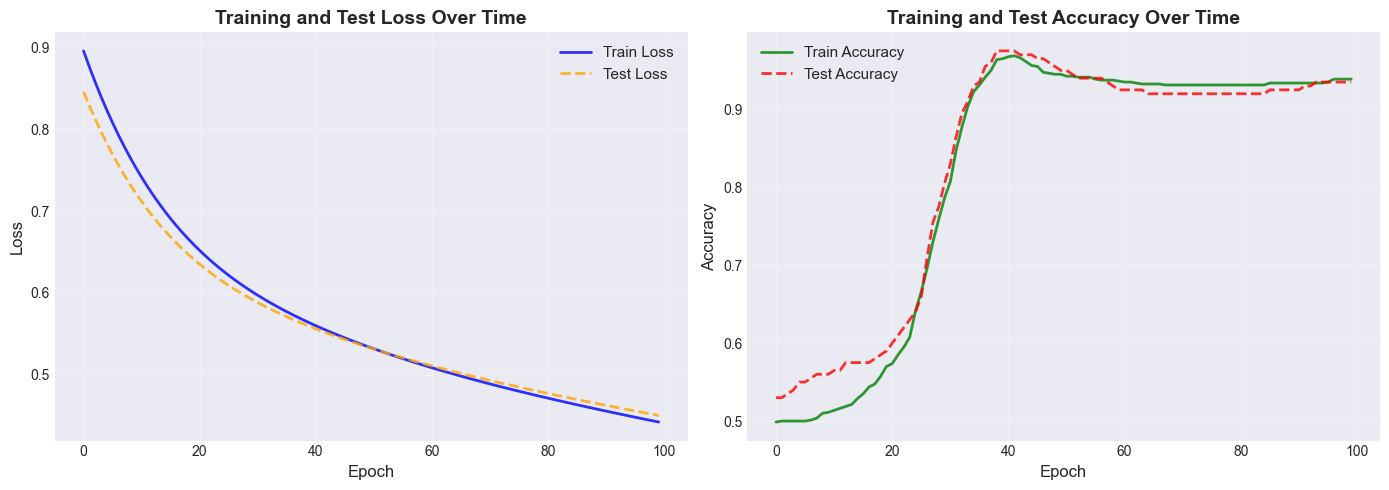


Training Analysis:
✅ Good Signs:
  • Loss decreases over time (model is learning)
  • Accuracy increases over time (model is improving)
  • Train and test curves are similar (model generalizes well)

⚠️ Warning Signs:
  • Train loss << Test loss → Overfitting (memorizing training data)
  • Train acc >> Test acc → Overfitting (not generalizing)
  • Loss not decreasing → Learning rate might be wrong, or model too simple


In [35]:
# ===== VISUALIZE TRAINING PROGRESS =====
# Plotting loss and accuracy helps us understand how training is progressing

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Loss plot - shows how error decreases over time
axes[0].plot(train_losses, label='Train Loss', linewidth=2, color='blue', alpha=0.8)
axes[0].plot(test_losses, label='Test Loss', linewidth=2, color='orange', alpha=0.8, linestyle='--')
axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('Loss', fontsize=12)
axes[0].set_title('Training and Test Loss Over Time', fontsize=14, fontweight='bold')
axes[0].legend(fontsize=11)
axes[0].grid(True, alpha=0.3)

# Accuracy plot - shows how performance improves over time
axes[1].plot(train_accuracies, label='Train Accuracy', linewidth=2, color='green', alpha=0.8)
axes[1].plot(test_accuracies, label='Test Accuracy', linewidth=2, color='red', alpha=0.8, linestyle='--')
axes[1].set_xlabel('Epoch', fontsize=12)
axes[1].set_ylabel('Accuracy', fontsize=12)
axes[1].set_title('Training and Test Accuracy Over Time', fontsize=14, fontweight='bold')
axes[1].legend(fontsize=11)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n" + "=" * 60)
print("Training Analysis:")
print("=" * 60)
print("✅ Good Signs:")
print("  • Loss decreases over time (model is learning)")
print("  • Accuracy increases over time (model is improving)")
print("  • Train and test curves are similar (model generalizes well)")
print("\n⚠️ Warning Signs:")
print("  • Train loss << Test loss → Overfitting (memorizing training data)")
print("  • Train acc >> Test acc → Overfitting (not generalizing)")
print("  • Loss not decreasing → Learning rate might be wrong, or model too simple")
print("=" * 60)


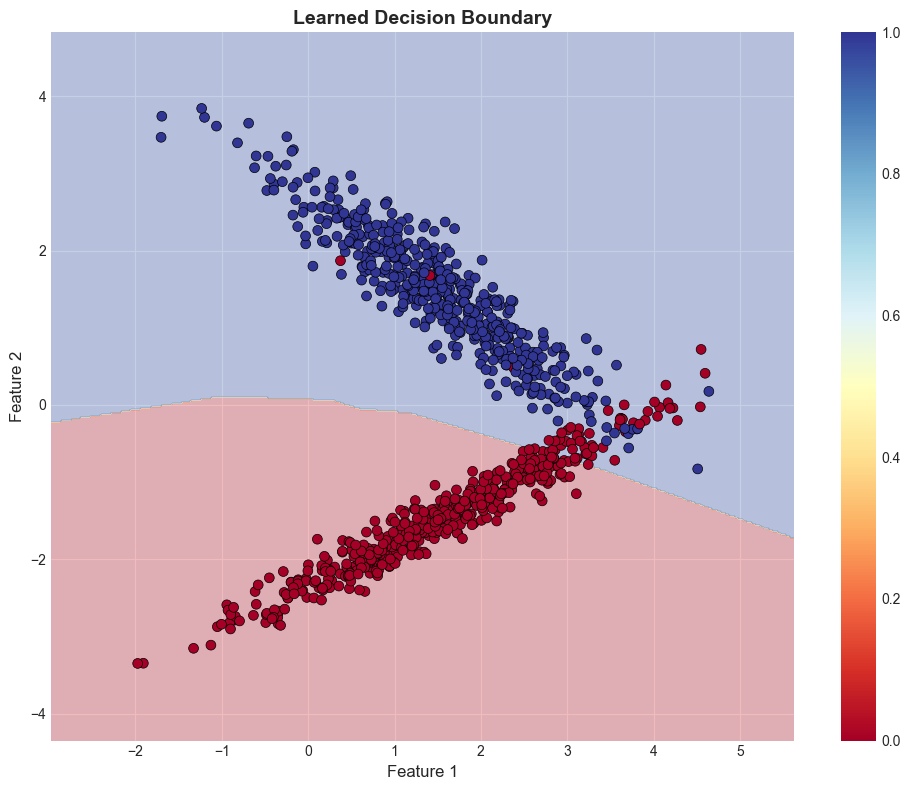

In [36]:
# Visualize decision boundary
def plot_decision_boundary(model, X, y):
    """Plot decision boundary learned by the model"""
    model.eval()
    
    # Convert to numpy if tensor
    if isinstance(X, torch.Tensor):
        X_np = X.numpy()
    else:
        X_np = np.array(X)
    
    if isinstance(y, torch.Tensor):
        y_np = y.numpy()
    else:
        y_np = np.array(y)
    
    # Create a mesh
    h = 0.02
    x_min, x_max = X_np[:, 0].min() - 1, X_np[:, 0].max() + 1
    y_min, y_max = X_np[:, 1].min() - 1, X_np[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    
    # Predict on mesh
    mesh_points = torch.FloatTensor(np.c_[xx.ravel(), yy.ravel()])
    with torch.no_grad():
        Z = model(mesh_points)
        Z = torch.argmax(Z, dim=1).numpy()
    
    Z = Z.reshape(xx.shape)
    
    # Plot
    plt.figure(figsize=(10, 8))
    plt.contourf(xx, yy, Z, alpha=0.3, cmap=plt.cm.RdYlBu)
    scatter = plt.scatter(X_np[:, 0], X_np[:, 1], c=y_np, cmap=plt.cm.RdYlBu, 
                          edgecolors='black', linewidths=0.5, s=50)
    plt.xlabel('Feature 1', fontsize=12)
    plt.ylabel('Feature 2', fontsize=12)
    plt.title('Learned Decision Boundary', fontsize=14, fontweight='bold')
    plt.colorbar(scatter)
    plt.tight_layout()
    plt.show()

plot_decision_boundary(model, X_tensor, y_tensor)


---

## Part 5: Optimization Algorithms - SGD, Momentum, RMSProp, and Adam

Understanding different optimization algorithms is crucial for training neural networks effectively. Each has its strengths and use cases.

### 1. Stochastic Gradient Descent (SGD)

**Update rule:** $w_{t+1} = w_t - \alpha \nabla_w L(w_t)$

- **Simple and intuitive**: Direct gradient descent
- **Fixed learning rate**: Same step size for all parameters
- **Pros**: Stable, predictable, good for convex problems
- **Cons**: Can be slow to converge, may oscillate in narrow valleys, can get stuck in local minima

### 2. SGD with Momentum

**Update rule:** 
- $v_t = \beta v_{t-1} + \nabla_w L(w_t)$ (velocity accumulates gradients)
- $w_{t+1} = w_t - \alpha v_t$

- **Momentum term** ($\beta$): Typically 0.9, accumulates past gradients
- **Pros**: Faster convergence, helps escape local minima, smoother updates
- **Cons**: May overshoot minima, requires tuning momentum coefficient

**Intuition**: Like a ball rolling down a hill - momentum helps it continue in the same direction, smoothing out oscillations.

### 3. RMSProp (Root Mean Square Propagation)

**Update rule:**
- $s_t = \beta s_{t-1} + (1-\beta)(\nabla_w L(w_t))^2$ (accumulates squared gradients)
- $w_{t+1} = w_t - \frac{\alpha}{\sqrt{s_t + \epsilon}} \nabla_w L(w_t)$

- **Adaptive learning rate**: Different step size per parameter
- **Pros**: Handles non-stationary objectives well, good for RNNs
- **Cons**: Can be sensitive to initial conditions, may converge to suboptimal solutions

**Intuition**: Adapts learning rate based on recent gradient magnitudes - smaller steps for parameters with large gradients.

### 4. Adam (Adaptive Moment Estimation)

**Update rule:** Combines Momentum + RMSProp
- $m_t = \beta_1 m_{t-1} + (1-\beta_1)\nabla_w L(w_t)$ (momentum)
- $v_t = \beta_2 v_{t-1} + (1-\beta_2)(\nabla_w L(w_t))^2$ (RMSProp)
- $w_{t+1} = w_t - \frac{\alpha}{\sqrt{v_t + \epsilon}} m_t$

- **Best of both worlds**: Momentum for direction + adaptive learning rates
- **Pros**: Fast convergence, works well in practice, default choice for many
- **Cons**: More hyperparameters, can sometimes generalize worse than SGD

**Intuition**: Like a smart ball that adjusts its speed based on the terrain (gradient history).

Let's compare all four side by side!


Training Models with Different Optimizers

1. Training with SGD (Simple Gradient Descent)...
   Learning rate: 0.01

2. Training with SGD + Momentum...
   Learning rate: 0.01, Momentum: 0.9

3. Training with RMSProp...
   Learning rate: 0.001 (adaptive optimizers need smaller LR)

4. Training with Adam...
   Learning rate: 0.001 (adaptive optimizers need smaller LR)

All optimizers trained! Now let's compare results...


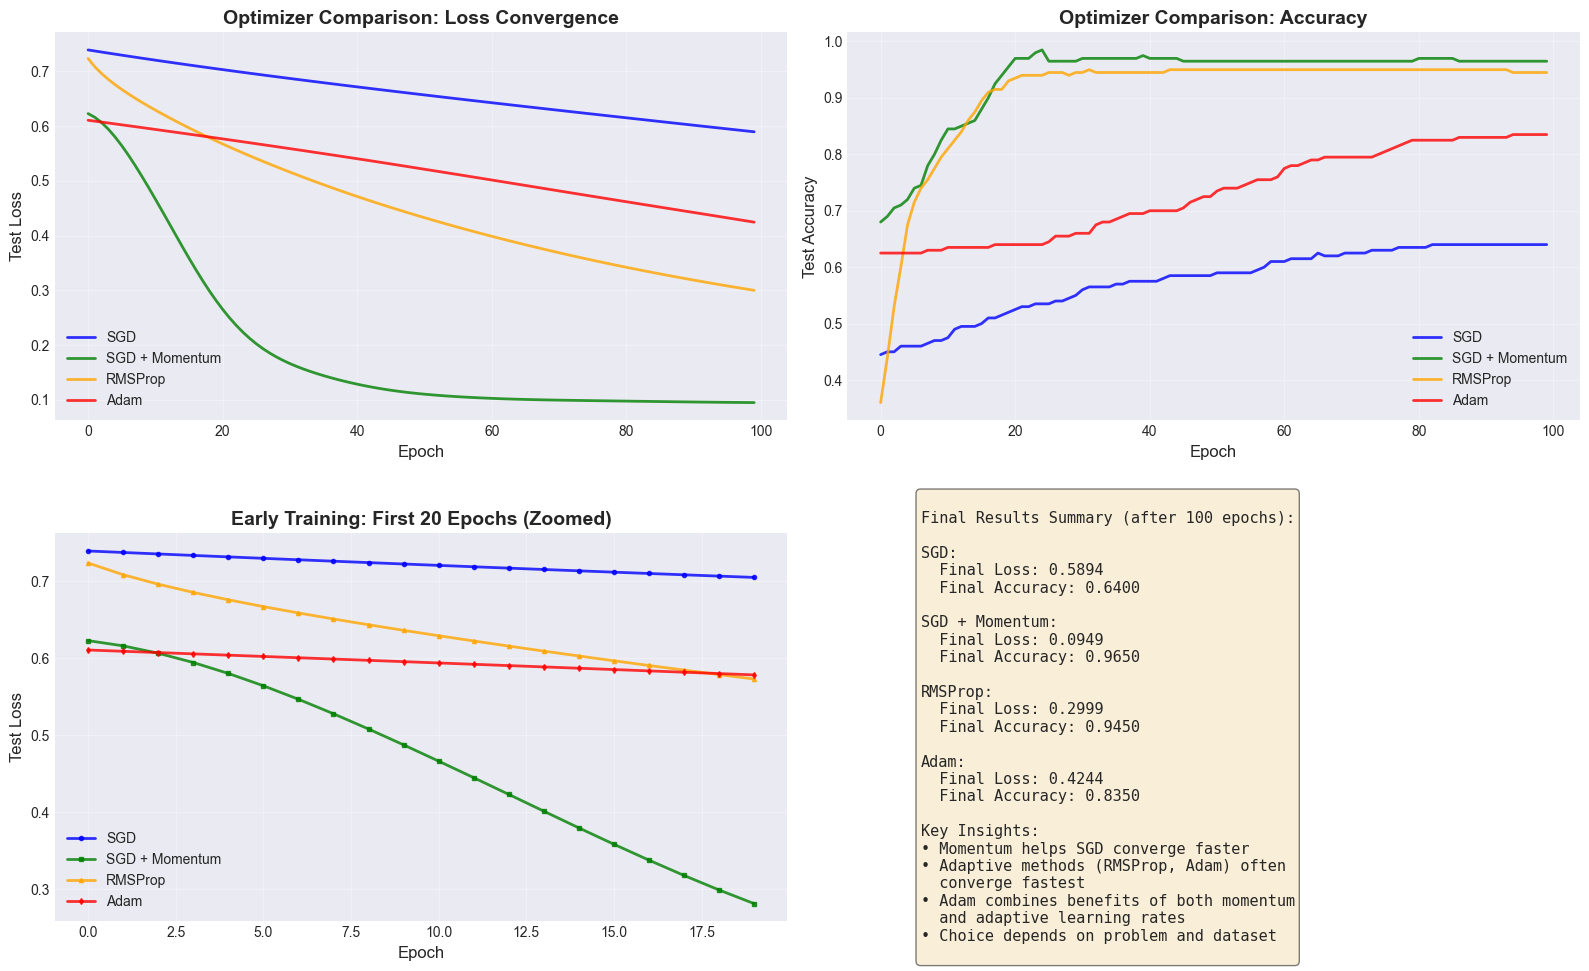


Detailed Comparison:
Optimizer            Final Loss      Final Accuracy 
------------------------------------------------------------
SGD                  0.5894          0.6400         
SGD + Momentum       0.0949          0.9650         
RMSProp              0.2999          0.9450         
Adam                 0.4244          0.8350         

When to Use Which Optimizer?
• SGD: Simple problems, when you want stability and interpretability
• Momentum: When SGD is too slow, helps escape local minima
• RMSProp: Non-stationary objectives, RNNs, when gradients vary widely
• Adam: Default choice for most deep learning, fast convergence, good generalization


In [37]:
# ===== COMPARE ALL OPTIMIZERS =====
# This function trains a model with a specific optimizer for fair comparison

def train_with_optimizer(optimizer_name, lr=0.01, num_epochs=100):
    """
    Train a model with a specified optimizer.
    
    Args:
        optimizer_name: 'SGD', 'Momentum', 'RMSProp', or 'Adam'
        lr: Learning rate (step size for weight updates)
        num_epochs: Number of training iterations
    Returns:
        losses: List of test losses over epochs
        accuracies: List of test accuracies over epochs
    """
    # Create fresh model for fair comparison (same initialization)
    model = SimpleNN(input_size=2, hidden_size=10, output_size=2)
    
    # Choose optimizer with appropriate learning rates
    # Note: Adaptive optimizers (RMSProp, Adam) typically need smaller learning rates
    if optimizer_name == 'SGD':
        optimizer = optim.SGD(model.parameters(), lr=lr)
    elif optimizer_name == 'Momentum':
        optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)  # SGD with momentum
    elif optimizer_name == 'RMSProp':
        optimizer = optim.RMSprop(model.parameters(), lr=lr)
    elif optimizer_name == 'Adam':
        optimizer = optim.Adam(model.parameters(), lr=lr)
    else:
        raise ValueError(f"Unknown optimizer: {optimizer_name}. Choose from: SGD, Momentum, RMSProp, Adam")
    
    criterion = nn.CrossEntropyLoss()
    losses = []
    accuracies = []
    
    # Training loop
    for epoch in range(num_epochs):
        model.train()
        outputs = model(X_train)
        loss = criterion(outputs, y_train)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Evaluate on test set
        model.eval()
        with torch.no_grad():
            test_outputs = model(X_test)
            test_loss = criterion(test_outputs, y_test)
            _, predicted = torch.max(test_outputs.data, 1)
            test_acc = (predicted == y_test).float().mean()
        
        losses.append(test_loss.item())
        accuracies.append(test_acc.item())
    
    return losses, accuracies

# Train with all four optimizers
print("=" * 60)
print("Training Models with Different Optimizers")
print("=" * 60)
print("\n1. Training with SGD (Simple Gradient Descent)...")
print("   Learning rate: 0.01")
sgd_losses, sgd_accuracies = train_with_optimizer('SGD', lr=0.01)

print("\n2. Training with SGD + Momentum...")
print("   Learning rate: 0.01, Momentum: 0.9")
momentum_losses, momentum_accuracies = train_with_optimizer('Momentum', lr=0.01)

print("\n3. Training with RMSProp...")
print("   Learning rate: 0.001 (adaptive optimizers need smaller LR)")
rmsprop_losses, rmsprop_accuracies = train_with_optimizer('RMSProp', lr=0.001)

print("\n4. Training with Adam...")
print("   Learning rate: 0.001 (adaptive optimizers need smaller LR)")
adam_losses, adam_accuracies = train_with_optimizer('Adam', lr=0.001)

print("\n" + "=" * 60)
print("All optimizers trained! Now let's compare results...")
print("=" * 60)

# ===== COMPREHENSIVE VISUALIZATION =====
# Compare all optimizers side by side

fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# Plot 1: Loss comparison (full training)
axes[0, 0].plot(sgd_losses, label='SGD', linewidth=2, alpha=0.8, color='blue')
axes[0, 0].plot(momentum_losses, label='SGD + Momentum', linewidth=2, alpha=0.8, color='green')
axes[0, 0].plot(rmsprop_losses, label='RMSProp', linewidth=2, alpha=0.8, color='orange')
axes[0, 0].plot(adam_losses, label='Adam', linewidth=2, alpha=0.8, color='red')
axes[0, 0].set_xlabel('Epoch', fontsize=12)
axes[0, 0].set_ylabel('Test Loss', fontsize=12)
axes[0, 0].set_title('Optimizer Comparison: Loss Convergence', fontsize=14, fontweight='bold')
axes[0, 0].legend(fontsize=10)
axes[0, 0].grid(True, alpha=0.3)

# Plot 2: Accuracy comparison (full training)
axes[0, 1].plot(sgd_accuracies, label='SGD', linewidth=2, alpha=0.8, color='blue')
axes[0, 1].plot(momentum_accuracies, label='SGD + Momentum', linewidth=2, alpha=0.8, color='green')
axes[0, 1].plot(rmsprop_accuracies, label='RMSProp', linewidth=2, alpha=0.8, color='orange')
axes[0, 1].plot(adam_accuracies, label='Adam', linewidth=2, alpha=0.8, color='red')
axes[0, 1].set_xlabel('Epoch', fontsize=12)
axes[0, 1].set_ylabel('Test Accuracy', fontsize=12)
axes[0, 1].set_title('Optimizer Comparison: Accuracy', fontsize=14, fontweight='bold')
axes[0, 1].legend(fontsize=10)
axes[0, 1].grid(True, alpha=0.3)

# Plot 3: Early convergence (first 20 epochs) - zoom in to see differences
axes[1, 0].plot(sgd_losses[:20], label='SGD', linewidth=2, alpha=0.8, marker='o', markersize=3, color='blue')
axes[1, 0].plot(momentum_losses[:20], label='SGD + Momentum', linewidth=2, alpha=0.8, marker='s', markersize=3, color='green')
axes[1, 0].plot(rmsprop_losses[:20], label='RMSProp', linewidth=2, alpha=0.8, marker='^', markersize=3, color='orange')
axes[1, 0].plot(adam_losses[:20], label='Adam', linewidth=2, alpha=0.8, marker='d', markersize=3, color='red')
axes[1, 0].set_xlabel('Epoch', fontsize=12)
axes[1, 0].set_ylabel('Test Loss', fontsize=12)
axes[1, 0].set_title('Early Training: First 20 Epochs (Zoomed)', fontsize=14, fontweight='bold')
axes[1, 0].legend(fontsize=10)
axes[1, 0].grid(True, alpha=0.3)

# Plot 4: Final results summary
axes[1, 1].axis('off')
summary_text = f"""
Final Results Summary (after {len(sgd_losses)} epochs):

SGD:
  Final Loss: {sgd_losses[-1]:.4f}
  Final Accuracy: {sgd_accuracies[-1]:.4f}
  
SGD + Momentum:
  Final Loss: {momentum_losses[-1]:.4f}
  Final Accuracy: {momentum_accuracies[-1]:.4f}
  
RMSProp:
  Final Loss: {rmsprop_losses[-1]:.4f}
  Final Accuracy: {rmsprop_accuracies[-1]:.4f}
  
Adam:
  Final Loss: {adam_losses[-1]:.4f}
  Final Accuracy: {adam_accuracies[-1]:.4f}

Key Insights:
• Momentum helps SGD converge faster
• Adaptive methods (RMSProp, Adam) often
  converge fastest
• Adam combines benefits of both momentum
  and adaptive learning rates
• Choice depends on problem and dataset
"""
axes[1, 1].text(0.1, 0.5, summary_text, fontsize=11, 
                verticalalignment='center', family='monospace',
                bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.show()

# Print detailed comparison
print("\n" + "=" * 60)
print("Detailed Comparison:")
print("=" * 60)
print(f"{'Optimizer':<20} {'Final Loss':<15} {'Final Accuracy':<15}")
print("-" * 60)
print(f"{'SGD':<20} {sgd_losses[-1]:<15.4f} {sgd_accuracies[-1]:<15.4f}")
print(f"{'SGD + Momentum':<20} {momentum_losses[-1]:<15.4f} {momentum_accuracies[-1]:<15.4f}")
print(f"{'RMSProp':<20} {rmsprop_losses[-1]:<15.4f} {rmsprop_accuracies[-1]:<15.4f}")
print(f"{'Adam':<20} {adam_losses[-1]:<15.4f} {adam_accuracies[-1]:<15.4f}")
print("=" * 60)

print("\n" + "=" * 60)
print("When to Use Which Optimizer?")
print("=" * 60)
print("• SGD: Simple problems, when you want stability and interpretability")
print("• Momentum: When SGD is too slow, helps escape local minima")
print("• RMSProp: Non-stationary objectives, RNNs, when gradients vary widely")
print("• Adam: Default choice for most deep learning, fast convergence, good generalization")
print("=" * 60)


### Learning Rate Selection: A Practical Guide

Choosing the right learning rate is crucial for training success. Here are some guidelines:

**General Rules:**
- **SGD**: Typically 0.01 - 0.1 (can be higher)
- **SGD + Momentum**: Similar to SGD (0.01 - 0.1)
- **RMSProp**: Typically 0.001 - 0.01 (often 10x smaller than SGD)
- **Adam**: Typically 0.0001 - 0.001 (often 100x smaller than SGD)

**Why the difference?**
- Adaptive optimizers (RMSProp, Adam) have built-in scaling, so they need smaller base learning rates
- SGD uses raw gradients, so it can handle larger learning rates

**Signs of wrong learning rate:**
- **Too high**: Loss explodes (becomes NaN), training is unstable, loss oscillates wildly
- **Too low**: Loss decreases very slowly, training takes forever, may get stuck in local minima

**Pro tip**: Start with the default/recommended learning rate for your optimizer, then adjust based on training behavior. A learning rate finder (gradually increasing LR and plotting loss) can help find optimal values.

Let's see what happens with different learning rates!


Testing different learning rates for Adam...


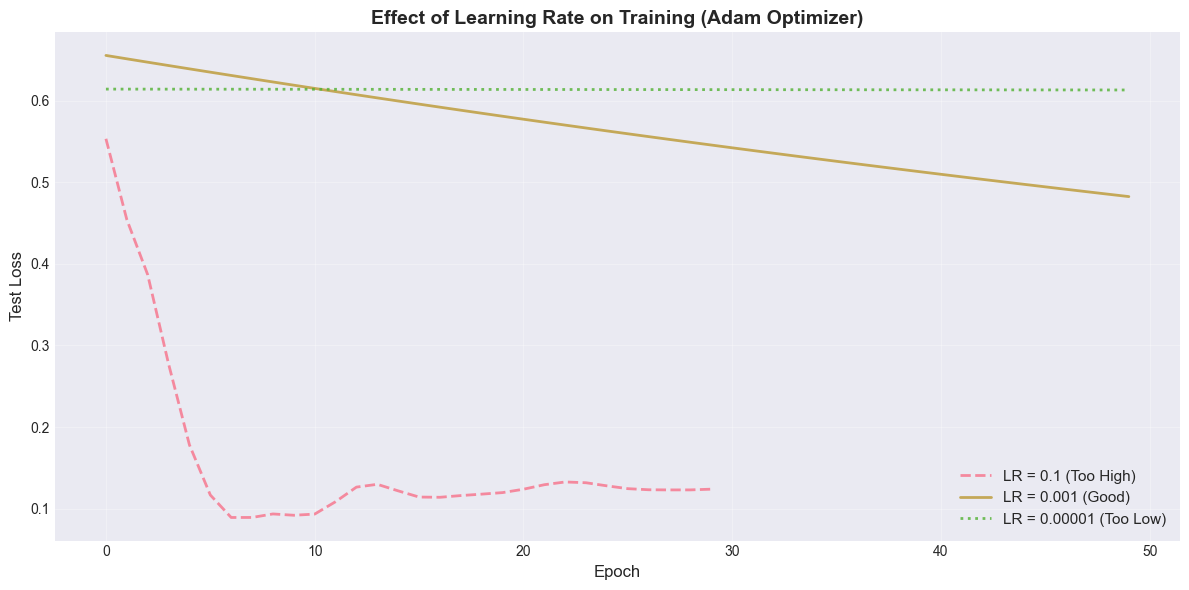


Observations:
• Too high LR: Loss may be unstable or explode (not shown here, but can happen)
• Good LR: Smooth, steady decrease in loss
• Too low LR: Loss decreases very slowly - would need many more epochs

💡 Finding the right learning rate is often a matter of experimentation!


In [38]:
# Quick demonstration: Effect of learning rate on training
def train_with_lr(optimizer_name, lr, num_epochs=50):
    """Train with specific learning rate"""
    model = SimpleNN(input_size=2, hidden_size=10, output_size=2)
    
    if optimizer_name == 'Adam':
        optimizer = optim.Adam(model.parameters(), lr=lr)
    else:
        optimizer = optim.SGD(model.parameters(), lr=lr)
    
    criterion = nn.CrossEntropyLoss()
    losses = []
    
    for epoch in range(num_epochs):
        model.train()
        outputs = model(X_train)
        loss = criterion(outputs, y_train)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        model.eval()
        with torch.no_grad():
            test_outputs = model(X_test)
            test_loss = criterion(test_outputs, y_test)
            losses.append(test_loss.item())
    
    return losses

# Test different learning rates for Adam
print("Testing different learning rates for Adam...")
lr_too_high = train_with_lr('Adam', lr=0.1, num_epochs=50)  # Too high
lr_good = train_with_lr('Adam', lr=0.001, num_epochs=50)     # Good
lr_too_low = train_with_lr('Adam', lr=0.00001, num_epochs=50) # Too low

# Visualize
fig, axes = plt.subplots(1, 1, figsize=(12, 6))
axes.plot(lr_too_high[:30], label='LR = 0.1 (Too High)', linewidth=2, alpha=0.8, linestyle='--')
axes.plot(lr_good, label='LR = 0.001 (Good)', linewidth=2, alpha=0.8)
axes.plot(lr_too_low, label='LR = 0.00001 (Too Low)', linewidth=2, alpha=0.8, linestyle=':')
axes.set_xlabel('Epoch', fontsize=12)
axes.set_ylabel('Test Loss', fontsize=12)
axes.set_title('Effect of Learning Rate on Training (Adam Optimizer)', fontsize=14, fontweight='bold')
axes.legend(fontsize=11)
axes.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("\nObservations:")
print("• Too high LR: Loss may be unstable or explode (not shown here, but can happen)")
print("• Good LR: Smooth, steady decrease in loss")
print("• Too low LR: Loss decreases very slowly - would need many more epochs")
print("\n💡 Finding the right learning rate is often a matter of experimentation!")


---

## Part 6: Dropout Regularization

### What is Overfitting?

When a model learns the training data **too well**, including noise and irrelevant patterns. This leads to poor performance on new data.

**Signs of overfitting:**
- Training accuracy >> Test accuracy
- Training loss << Test loss

### Dropout: A Simple but Powerful Regularization Technique

**Idea:** Randomly "turn off" (set to zero) some neurons during training with probability $p$.

- Forces the network to not rely on specific neurons
- Creates an ensemble effect (averaging over many subnetworks)
- **Only active during training** - all neurons are used during inference

**Dropout rate:** Typically 0.2-0.5 (20-50% of neurons dropped)


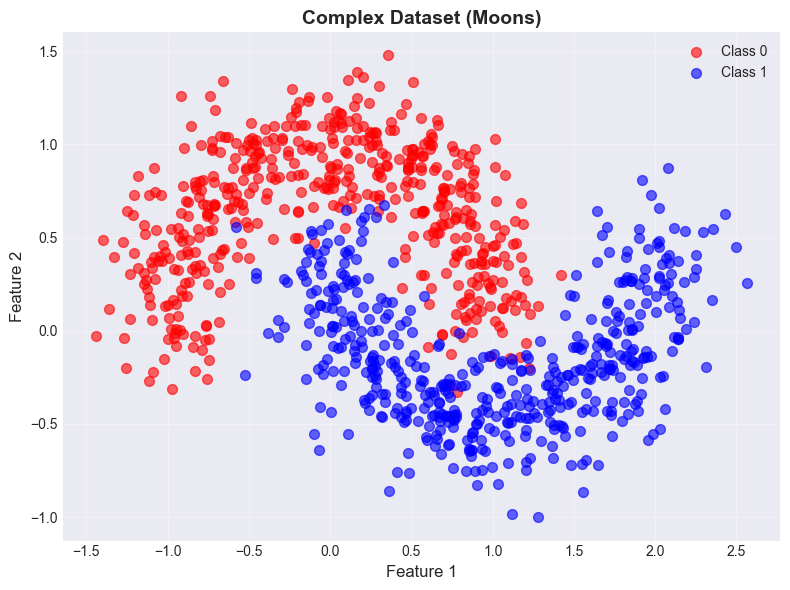

In [ ]:
# ===== CREATE COMPLEX DATASET FOR OVERFITTING DEMONSTRATION =====
# Moons dataset has a non-linear decision boundary - perfect for showing overfitting
X_complex, y_complex = make_moons(n_samples=1000, noise=0.2, random_state=42)

# Convert to PyTorch tensors
X_complex_tensor = torch.FloatTensor(X_complex)
y_complex_tensor = torch.LongTensor(y_complex)

# Split into training and test sets
X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(
    X_complex_tensor, y_complex_tensor, test_size=0.2, random_state=42
)

# Visualize the complex dataset
plt.figure(figsize=(8, 6))
plt.scatter(X_complex[y_complex==0, 0], X_complex[y_complex==0, 1], 
            c='red', alpha=0.6, label='Class 0', s=50, edgecolors='black', linewidths=0.5)
plt.scatter(X_complex[y_complex==1, 0], X_complex[y_complex==1, 1], 
            c='blue', alpha=0.6, label='Class 1', s=50, edgecolors='black', linewidths=0.5)
plt.xlabel('Feature 1', fontsize=12)
plt.ylabel('Feature 2', fontsize=12)
plt.title('Moons Dataset - Non-Linear Decision Boundary', fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("=" * 60)
print("Dataset Information:")
print("=" * 60)
print(f"Total samples: {len(X_complex_tensor)}")
print(f"Training samples: {len(X_train_c)}")
print(f"Test samples: {len(X_test_c)}")
print("\n💡 This dataset is more complex - requires non-linear decision boundary")
print("💡 Perfect for demonstrating overfitting with larger networks!")
print("=" * 60)


In [ ]:
# ===== DEFINE TWO MODELS: WITH AND WITHOUT DROPOUT =====

# Model WITHOUT dropout (will likely overfit)
class ModelNoDropout(nn.Module):
    """
    Larger network without dropout - prone to overfitting.
    Architecture: 2 → 50 → 50 → 2
    """
    def __init__(self, input_size=2, hidden_size=50, output_size=2):
        super(ModelNoDropout, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)      # First hidden layer
        self.relu1 = nn.ReLU()                              # Activation
        self.fc2 = nn.Linear(hidden_size, hidden_size)     # Second hidden layer
        self.relu2 = nn.ReLU()                              # Activation
        self.fc3 = nn.Linear(hidden_size, output_size)      # Output layer
    
    def forward(self, x):
        out = self.fc1(x)
        out = self.relu1(out)
        out = self.fc2(out)
        out = self.relu2(out)
        out = self.fc3(out)
        return out

# Model WITH dropout (will generalize better)
class ModelWithDropout(nn.Module):
    """
    Same architecture but WITH dropout to prevent overfitting.
    Dropout randomly turns off neurons during training.
    """
    def __init__(self, input_size=2, hidden_size=50, output_size=2, dropout_rate=0.5):
        super(ModelWithDropout, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(dropout_rate)  # 50% dropout
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(dropout_rate)  # 50% dropout
        self.fc3 = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        out = self.fc1(x)
        out = self.relu1(out)
        out = self.dropout1(out)  # Dropout only active during training (when model.train() is called)
        out = self.fc2(out)
        out = self.relu2(out)
        out = self.dropout2(out)  # Dropout only active during training
        out = self.fc3(out)
        return out

print("=" * 60)
print("Model Architectures:")
print("=" * 60)
print("\nModel WITHOUT Dropout:")
print("-" * 60)
print(ModelNoDropout())
print("\nModel WITH Dropout:")
print("-" * 60)
print(ModelWithDropout())
print("\n" + "=" * 60)
print("💡 Key Difference: Dropout layers randomly turn off 50% of neurons during training")
print("   This prevents the network from over-relying on specific neurons!")
print("=" * 60)


Model without dropout:
ModelNoDropout(
  (fc1): Linear(in_features=2, out_features=50, bias=True)
  (relu1): ReLU()
  (fc2): Linear(in_features=50, out_features=50, bias=True)
  (relu2): ReLU()
  (fc3): Linear(in_features=50, out_features=2, bias=True)
)

Model with dropout:
ModelWithDropout(
  (fc1): Linear(in_features=2, out_features=50, bias=True)
  (relu1): ReLU()
  (dropout1): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=50, out_features=50, bias=True)
  (relu2): ReLU()
  (dropout2): Dropout(p=0.5, inplace=False)
  (fc3): Linear(in_features=50, out_features=2, bias=True)
)


In [41]:
# ===== TRAINING FUNCTION =====
def train_model(model, X_train, y_train, X_test, y_test, num_epochs=200):
    """
    Train a model and track training/test metrics.
    
    Args:
        model: Neural network model
        X_train, y_train: Training data
        X_test, y_test: Test data
        num_epochs: Number of training epochs
    Returns:
        train_losses, train_accs, test_losses, test_accs
    """
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)  # Adam optimizer
    
    train_losses = []
    train_accs = []
    test_losses = []
    test_accs = []
    
    for epoch in range(num_epochs):
        # ===== TRAINING =====
        model.train()  # Enable dropout (if present)
        train_outputs = model(X_train)
        train_loss = criterion(train_outputs, y_train)
        
        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()
        
        train_acc = (torch.argmax(train_outputs, dim=1) == y_train).float().mean()
        
        # ===== EVALUATION =====
        model.eval()  # Disable dropout (if present) - all neurons active during testing!
        with torch.no_grad():
            test_outputs = model(X_test)
            test_loss = criterion(test_outputs, y_test)
            test_acc = (torch.argmax(test_outputs, dim=1) == y_test).float().mean()
        
        # Store metrics
        train_losses.append(train_loss.item())
        train_accs.append(train_acc.item())
        test_losses.append(test_loss.item())
        test_accs.append(test_acc.item())
    
    return train_losses, train_accs, test_losses, test_accs

# Train both models
print("=" * 60)
print("Training Models to Compare Dropout Effect")
print("=" * 60)
print("\n1. Training model WITHOUT dropout...")
print("   (This model will likely overfit - memorize training data)")
model_no_dropout = ModelNoDropout()
train_loss_no_drop, train_acc_no_drop, test_loss_no_drop, test_acc_no_drop = train_model(
    model_no_dropout, X_train_c, y_train_c, X_test_c, y_test_c
)

print("\n2. Training model WITH dropout...")
print("   (This model should generalize better - work on new data)")
model_with_dropout = ModelWithDropout()
train_loss_drop, train_acc_drop, test_loss_drop, test_acc_drop = train_model(
    model_with_dropout, X_train_c, y_train_c, X_test_c, y_test_c
)

print("\n" + "=" * 60)
print("Training Complete! Analyzing results...")
print("=" * 60)


Training model WITHOUT dropout...
Training model WITH dropout...


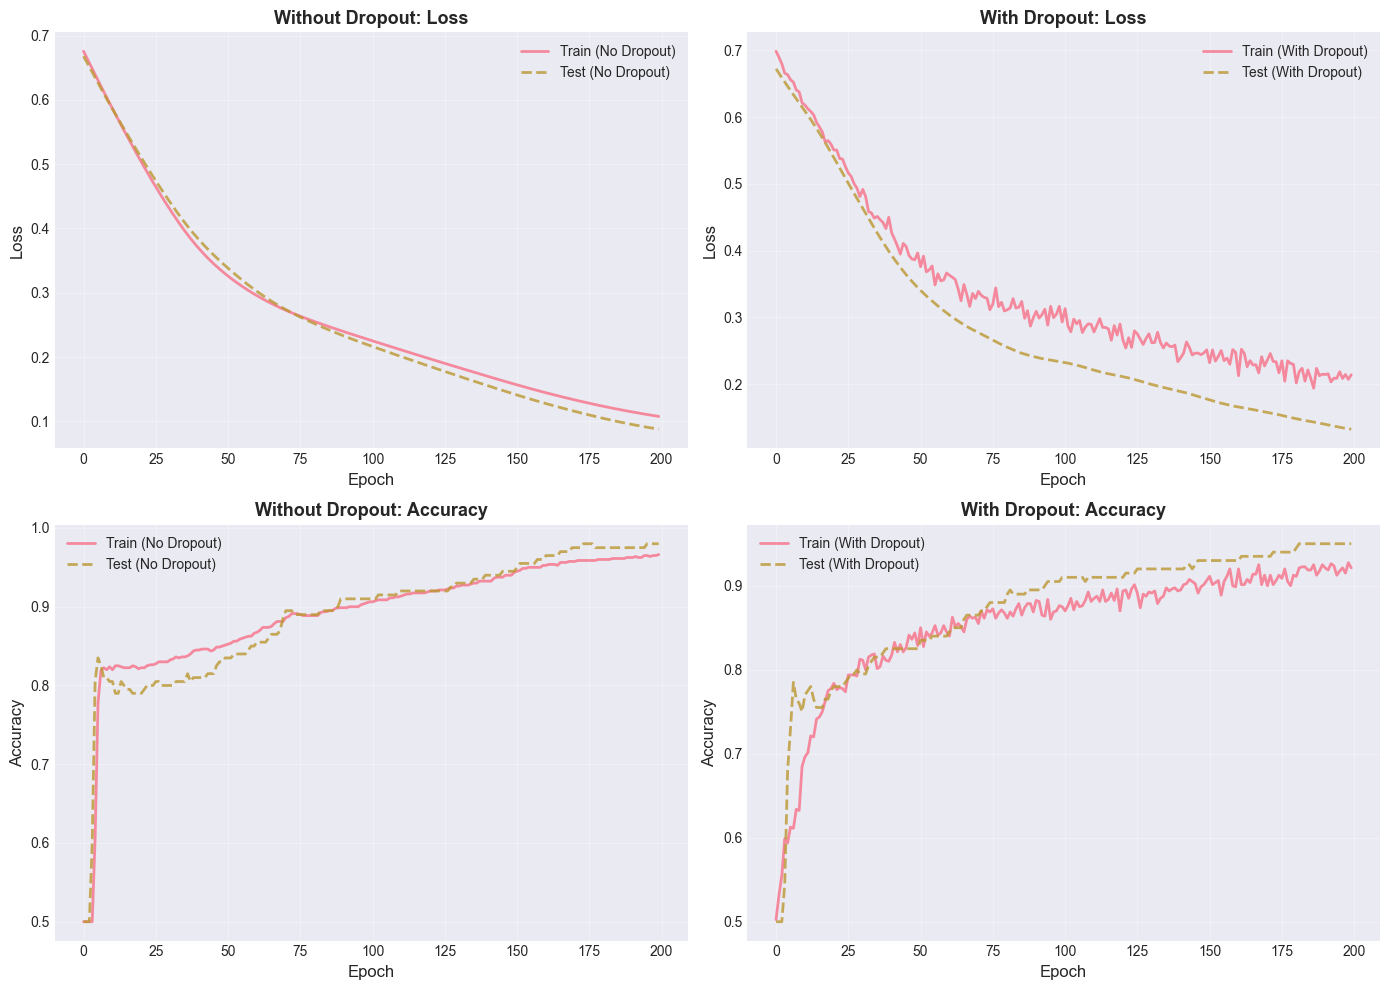


=== Overfitting Analysis ===
Without Dropout:
  Train Accuracy: 0.9663
  Test Accuracy: 0.9800
  Gap (Overfitting): -0.0138

With Dropout:
  Train Accuracy: 0.9212
  Test Accuracy: 0.9500
  Gap (Overfitting): -0.0288

Dropout reduced overfitting by: 0.0150


In [42]:
# ===== VISUALIZE OVERFITTING COMPARISON =====
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Loss: Without dropout
axes[0, 0].plot(train_loss_no_drop, label='Train', linewidth=2, alpha=0.8, color='blue')
axes[0, 0].plot(test_loss_no_drop, label='Test', linewidth=2, alpha=0.8, color='orange', linestyle='--')
axes[0, 0].set_xlabel('Epoch', fontsize=12)
axes[0, 0].set_ylabel('Loss', fontsize=12)
axes[0, 0].set_title('Without Dropout: Loss', fontsize=13, fontweight='bold')
axes[0, 0].legend(fontsize=11)
axes[0, 0].grid(True, alpha=0.3)

# Loss: With dropout
axes[0, 1].plot(train_loss_drop, label='Train', linewidth=2, alpha=0.8, color='blue')
axes[0, 1].plot(test_loss_drop, label='Test', linewidth=2, alpha=0.8, color='orange', linestyle='--')
axes[0, 1].set_xlabel('Epoch', fontsize=12)
axes[0, 1].set_ylabel('Loss', fontsize=12)
axes[0, 1].set_title('With Dropout: Loss', fontsize=13, fontweight='bold')
axes[0, 1].legend(fontsize=11)
axes[0, 1].grid(True, alpha=0.3)

# Accuracy: Without dropout
axes[1, 0].plot(train_acc_no_drop, label='Train', linewidth=2, alpha=0.8, color='green')
axes[1, 0].plot(test_acc_no_drop, label='Test', linewidth=2, alpha=0.8, color='red', linestyle='--')
axes[1, 0].set_xlabel('Epoch', fontsize=12)
axes[1, 0].set_ylabel('Accuracy', fontsize=12)
axes[1, 0].set_title('Without Dropout: Accuracy', fontsize=13, fontweight='bold')
axes[1, 0].legend(fontsize=11)
axes[1, 0].grid(True, alpha=0.3)

# Accuracy: With dropout
axes[1, 1].plot(train_acc_drop, label='Train', linewidth=2, alpha=0.8, color='green')
axes[1, 1].plot(test_acc_drop, label='Test', linewidth=2, alpha=0.8, color='red', linestyle='--')
axes[1, 1].set_xlabel('Epoch', fontsize=12)
axes[1, 1].set_ylabel('Accuracy', fontsize=12)
axes[1, 1].set_title('With Dropout: Accuracy', fontsize=13, fontweight='bold')
axes[1, 1].legend(fontsize=11)
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Calculate overfitting gap (difference between train and test accuracy)
overfitting_gap_no_drop = train_acc_no_drop[-1] - test_acc_no_drop[-1]
overfitting_gap_drop = train_acc_drop[-1] - test_acc_drop[-1]

print("\n" + "=" * 60)
print("Overfitting Analysis:")
print("=" * 60)
print(f"\nWithout Dropout:")
print(f"  Train Accuracy: {train_acc_no_drop[-1]:.4f} ({train_acc_no_drop[-1]:.2%})")
print(f"  Test Accuracy:  {test_acc_no_drop[-1]:.4f} ({test_acc_no_drop[-1]:.2%})")
print(f"  Gap (Overfitting): {overfitting_gap_no_drop:.4f} ({overfitting_gap_no_drop:.2%})")
print(f"\nWith Dropout:")
print(f"  Train Accuracy: {train_acc_drop[-1]:.4f} ({train_acc_drop[-1]:.2%})")
print(f"  Test Accuracy:  {test_acc_drop[-1]:.4f} ({test_acc_drop[-1]:.2%})")
print(f"  Gap (Overfitting): {overfitting_gap_drop:.4f} ({overfitting_gap_drop:.2%})")
print("=" * 60)
print(f"\n💡 Key Insight: Dropout reduced overfitting by {abs(overfitting_gap_no_drop - overfitting_gap_drop):.4f} ({abs(overfitting_gap_no_drop - overfitting_gap_drop):.2%})")
print("   Smaller gap = better generalization to new data!")
print("=" * 60)


---

## Part 7: Weight and Gradient Inspection - Debugging Neural Networks

Understanding what's happening inside your network is crucial for debugging and improving performance.

### What to Inspect:
1. **Weight distributions** - Are weights too large/small? Initialization matters!
2. **Gradient magnitudes** - Vanishing/exploding gradients?
3. **Activation statistics** - Are neurons dying? (ReLU problem)

Let's build tools to inspect these!


Initial weights:


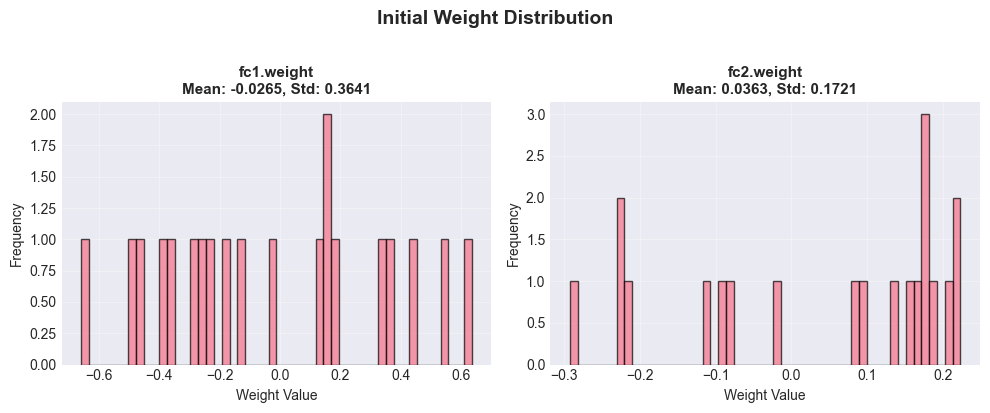

In [43]:
# Function to inspect weights
def inspect_weights(model, title="Weight Distribution"):
    """Plot weight distributions for each layer"""
    # Count weight layers
    weight_layers = [name for name, param in model.named_parameters() if 'weight' in name]
    num_layers = len(weight_layers)
    
    if num_layers == 0:
        print("No weight layers found in model")
        return
    
    fig, axes = plt.subplots(1, num_layers, figsize=(5*num_layers, 4))
    # Ensure axes is always an array
    if num_layers == 1:
        axes = [axes]
    else:
        axes = axes.flatten()
    
    layer_idx = 0
    for name, param in model.named_parameters():
        if 'weight' in name:
            weights = param.data.flatten().numpy()
            
            axes[layer_idx].hist(weights, bins=50, alpha=0.7, edgecolor='black')
            axes[layer_idx].set_title(f'{name}\nMean: {weights.mean():.4f}, Std: {weights.std():.4f}', 
                                     fontsize=11, fontweight='bold')
            axes[layer_idx].set_xlabel('Weight Value', fontsize=10)
            axes[layer_idx].set_ylabel('Frequency', fontsize=10)
            axes[layer_idx].grid(True, alpha=0.3)
            layer_idx += 1
    
    plt.suptitle(title, fontsize=14, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.show()

# Function to inspect gradients
def inspect_gradients(model, title="Gradient Distribution"):
    """Plot gradient distributions for each layer"""
    # Count weight layers with gradients
    weight_layers = [name for name, param in model.named_parameters() 
                     if 'weight' in name and param.grad is not None]
    num_layers = len(weight_layers)
    
    if num_layers == 0:
        print("No gradients found in model. Run backward() first.")
        return
    
    fig, axes = plt.subplots(1, num_layers, figsize=(5*num_layers, 4))
    # Ensure axes is always an array
    if num_layers == 1:
        axes = [axes]
    else:
        axes = axes.flatten()
    
    layer_idx = 0
    for name, param in model.named_parameters():
        if 'weight' in name and param.grad is not None:
            grads = param.grad.data.flatten().numpy()
            
            axes[layer_idx].hist(grads, bins=50, alpha=0.7, edgecolor='black', color='orange')
            axes[layer_idx].set_title(f'{name}\nMean: {grads.mean():.4f}, Std: {grads.std():.4f}', 
                                     fontsize=11, fontweight='bold')
            axes[layer_idx].set_xlabel('Gradient Value', fontsize=10)
            axes[layer_idx].set_ylabel('Frequency', fontsize=10)
            axes[layer_idx].grid(True, alpha=0.3)
            layer_idx += 1
    
    plt.suptitle(title, fontsize=14, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.show()

# Create a model and inspect
inspect_model = SimpleNN(input_size=2, hidden_size=10, output_size=2)
print("Initial weights:")
inspect_weights(inspect_model, "Initial Weight Distribution")


Gradients after one backward pass:


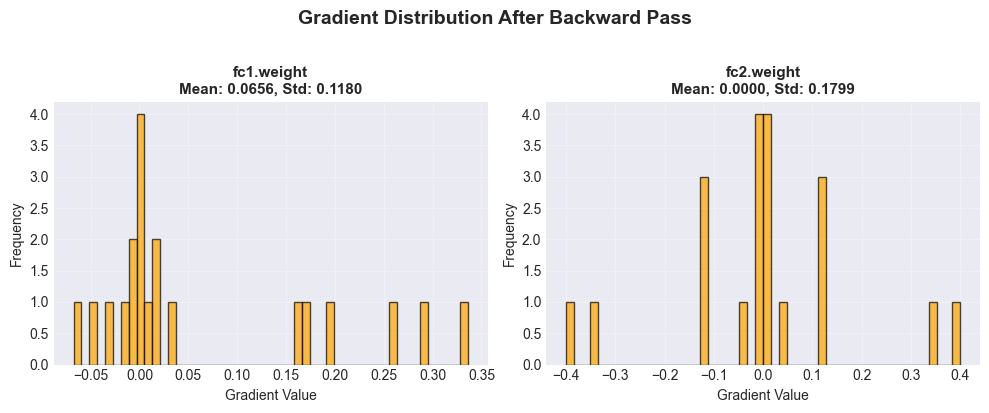


=== Gradient Statistics ===
fc1.weight:
  Mean: 0.065601, Std: 0.121078, Max abs: 0.335977
fc1.bias:
  Mean: 0.036534, Std: 0.065000, Max abs: 0.138446
fc2.weight:
  Mean: 0.000000, Std: 0.184555, Max abs: 0.399698
fc2.bias:
  Mean: 0.000000, Std: 0.432792, Max abs: 0.306030


In [44]:
# Train for a few steps and inspect gradients
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(inspect_model.parameters(), lr=0.01)

# Forward and backward pass
outputs = inspect_model(X_train[:100])
loss = criterion(outputs, y_train[:100])
optimizer.zero_grad()
loss.backward()

print("Gradients after one backward pass:")
inspect_gradients(inspect_model, "Gradient Distribution After Backward Pass")

# Print gradient statistics
print("\n=== Gradient Statistics ===")
for name, param in inspect_model.named_parameters():
    if param.grad is not None:
        grad_mean = param.grad.data.mean().item()
        grad_std = param.grad.data.std().item()
        grad_max = param.grad.data.abs().max().item()
        print(f"{name}:")
        print(f"  Mean: {grad_mean:.6f}, Std: {grad_std:.6f}, Max abs: {grad_max:.6f}")
        
        # Check for vanishing/exploding gradients
        if grad_max < 1e-6:
            print(f"  ⚠️  WARNING: Very small gradients (vanishing gradient problem!)")
        elif grad_max > 100:
            print(f"  ⚠️  WARNING: Very large gradients (exploding gradient problem!)")


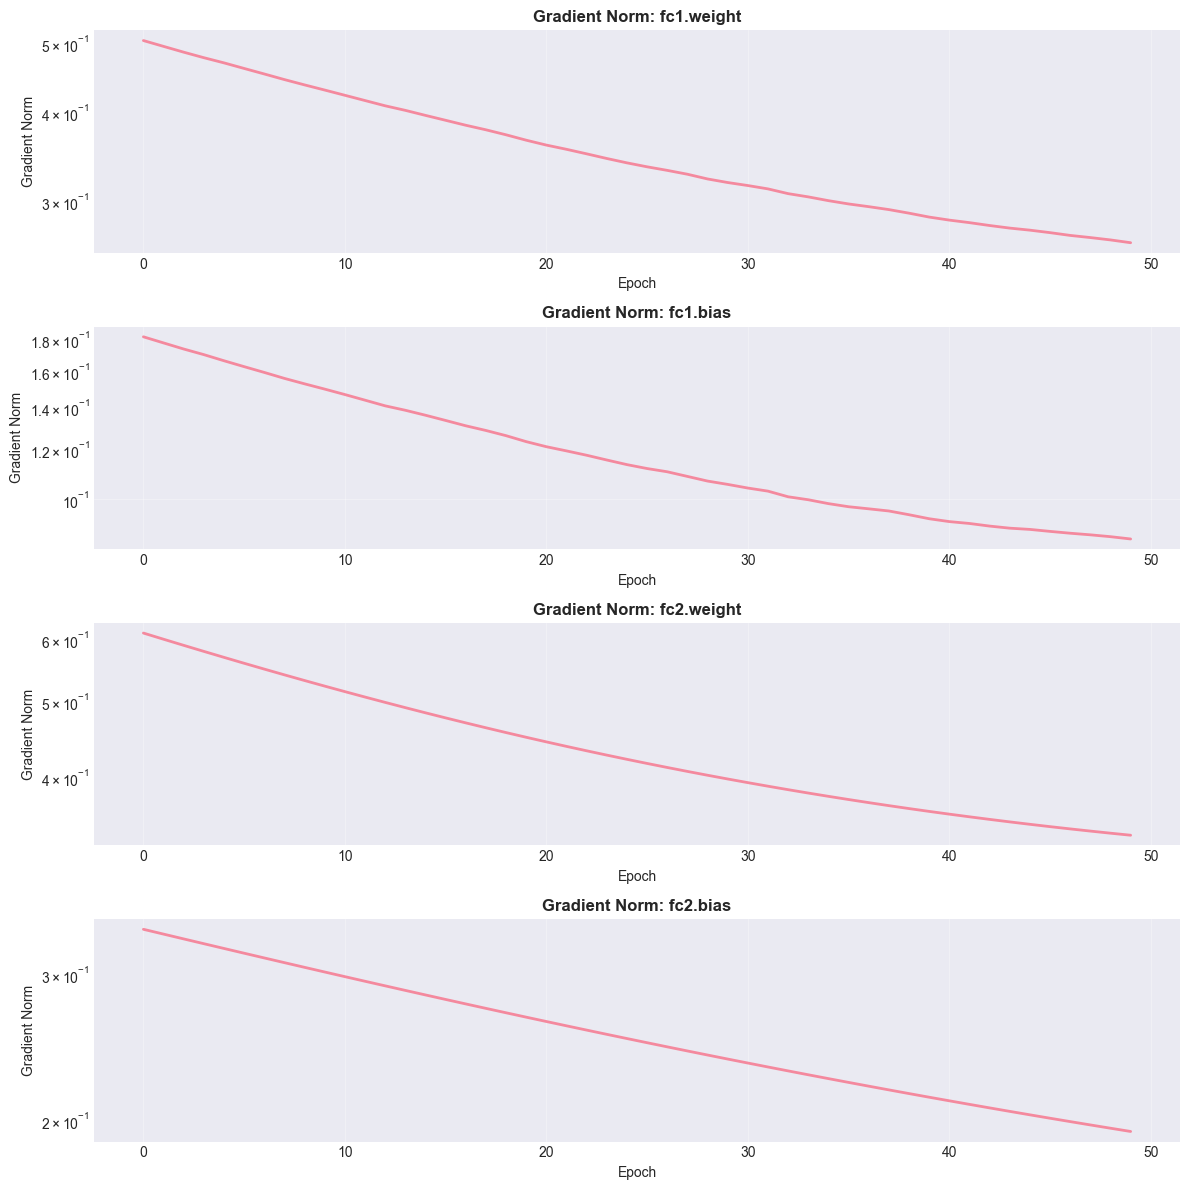

Key insights:
- Gradient norms should be stable (not too small, not exploding)
- If gradients vanish → network stops learning
- If gradients explode → training becomes unstable


In [45]:
# Track gradients during training
def train_and_track_gradients(model, X_train, y_train, num_epochs=50):
    """Train model and track gradient statistics"""
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.01)
    
    gradient_norms = {name: [] for name, _ in model.named_parameters()}
    
    for epoch in range(num_epochs):
        model.train()
        outputs = model(X_train)
        loss = criterion(outputs, y_train)
        
        optimizer.zero_grad()
        loss.backward()
        
        # Record gradient norms
        for name, param in model.named_parameters():
            if param.grad is not None:
                grad_norm = param.grad.data.norm().item()
                gradient_norms[name].append(grad_norm)
        
        optimizer.step()
    
    return gradient_norms

# Train and track
gradient_history = train_and_track_gradients(inspect_model, X_train, y_train, num_epochs=50)

# Plot gradient norms over time
num_params = len(gradient_history)
if num_params == 0:
    print("No gradient history to plot")
else:
    fig, axes = plt.subplots(num_params, 1, figsize=(12, 3*num_params))
    # Ensure axes is always an array
    if num_params == 1:
        axes = [axes]
    else:
        axes = axes.flatten()
    
    for idx, (name, norms) in enumerate(gradient_history.items()):
        axes[idx].plot(norms, linewidth=2, alpha=0.8)
        axes[idx].set_title(f'Gradient Norm: {name}', fontsize=12, fontweight='bold')
        axes[idx].set_xlabel('Epoch', fontsize=10)
        axes[idx].set_ylabel('Gradient Norm', fontsize=10)
        axes[idx].grid(True, alpha=0.3)
        axes[idx].set_yscale('log')  # Log scale to see small changes
    
    plt.tight_layout()
    plt.show()

print("Key insights:")
print("- Gradient norms should be stable (not too small, not exploding)")
print("- If gradients vanish → network stops learning")
print("- If gradients explode → training becomes unstable")


Inspecting activations...


/var/folders/b4/580wvvsn6p3gd7mh3mx84l5m0000gn/T/ipykernel_14582/1229473965.py:60: UserWarning: Glyph 9888 (\N{WARNING SIGN}) missing from font(s) Arial.
  plt.tight_layout()
/var/folders/b4/580wvvsn6p3gd7mh3mx84l5m0000gn/T/ipykernel_14582/1229473965.py:60: UserWarning: Glyph 65039 (\N{VARIATION SELECTOR-16}) missing from font(s) Arial.
  plt.tight_layout()
/Users/varunraste/Library/Python/3.9/lib/python/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 9888 (\N{WARNING SIGN}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/varunraste/Library/Python/3.9/lib/python/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 65039 (\N{VARIATION SELECTOR-16}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


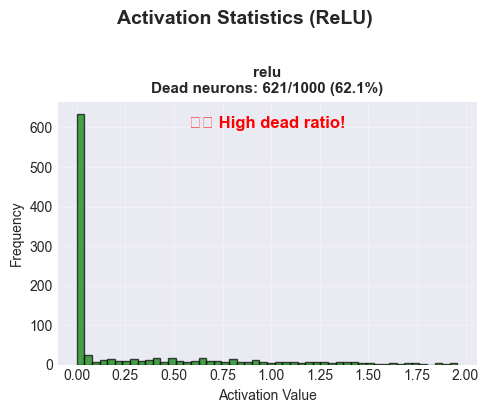

In [46]:
# Inspect activations (check for dying ReLU problem)
def inspect_activations(model, X_sample):
    """Check activation statistics to detect dying ReLU"""
    model.eval()
    
    activations = {}
    
    def hook_fn(name):
        def hook(module, input, output):
            activations[name] = output.detach()
        return hook
    
    # Register hooks
    hooks = []
    for name, module in model.named_modules():
        if isinstance(module, nn.ReLU):
            hook = module.register_forward_hook(hook_fn(name))
            hooks.append(hook)
    
    # Forward pass
    with torch.no_grad():
        _ = model(X_sample)
    
    # Remove hooks
    for hook in hooks:
        hook.remove()
    
    if len(activations) == 0:
        print("No ReLU layers found in model")
        return {}
    
    # Plot activation distributions
    num_activations = len(activations)
    fig, axes = plt.subplots(1, num_activations, figsize=(5*num_activations, 4))
    # Ensure axes is always an array
    if num_activations == 1:
        axes = [axes]
    else:
        axes = axes.flatten()
    
    for idx, (name, act) in enumerate(activations.items()):
        act_flat = act.flatten().numpy()
        dead_neurons = (act_flat == 0).sum()
        total_neurons = len(act_flat)
        dead_ratio = dead_neurons / total_neurons
        
        axes[idx].hist(act_flat, bins=50, alpha=0.7, edgecolor='black', color='green')
        axes[idx].set_title(f'{name}\nDead neurons: {dead_neurons}/{total_neurons} ({dead_ratio:.1%})', 
                           fontsize=11, fontweight='bold')
        axes[idx].set_xlabel('Activation Value', fontsize=10)
        axes[idx].set_ylabel('Frequency', fontsize=10)
        axes[idx].grid(True, alpha=0.3)
        
        if dead_ratio > 0.5:
            axes[idx].text(0.5, 0.9, '⚠️ High dead ratio!', 
                          transform=axes[idx].transAxes, 
                          fontsize=12, ha='center', color='red', fontweight='bold')
    
    plt.suptitle('Activation Statistics (ReLU)', fontsize=14, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.show()
    
    return activations

# Inspect activations
print("Inspecting activations...")
activations = inspect_activations(inspect_model, X_train[:100])


---

## Part 8: Putting It All Together - Complete Training Example

Let's build a complete training script that incorporates everything we've learned:

1. ✅ Proper model architecture
2. ✅ Activation functions (ReLU + Tanh comparison)
3. ✅ Explicit training loop
4. ✅ Loss visualization
5. ✅ Gradient inspection
6. ✅ Dropout regularization
7. ✅ Optimizer comparison


In [47]:
# Final comprehensive model
class ComprehensiveNN(nn.Module):
    """Neural network with ReLU and Tanh activations"""
    
    def __init__(self, input_size=2, hidden_size=20, output_size=2, use_tanh=False, dropout_rate=0.3):
        super(ComprehensiveNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, output_size)
        
        # Choose activation
        if use_tanh:
            self.activation = nn.Tanh()
        else:
            self.activation = nn.ReLU()
        
        self.dropout = nn.Dropout(dropout_rate)
    
    def forward(self, x):
        out = self.fc1(x)
        out = self.activation(out)
        out = self.dropout(out)
        
        out = self.fc2(out)
        out = self.activation(out)
        out = self.dropout(out)
        
        out = self.fc3(out)
        return out

# Complete training function with all monitoring
def comprehensive_train(model, X_train, y_train, X_test, y_test, 
                        optimizer_name='Adam', lr=0.001, num_epochs=100):
    """Complete training with full monitoring"""
    
    criterion = nn.CrossEntropyLoss()
    
    if optimizer_name == 'SGD':
        optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)
    else:
        optimizer = optim.Adam(model.parameters(), lr=lr)
    
    train_losses = []
    test_losses = []
    train_accs = []
    test_accs = []
    gradient_norms = []
    
    for epoch in range(num_epochs):
        # Training
        model.train()
        train_outputs = model(X_train)
        train_loss = criterion(train_outputs, y_train)
        
        optimizer.zero_grad()
        train_loss.backward()
        
        # Track gradient norm
        total_grad_norm = 0
        for param in model.parameters():
            if param.grad is not None:
                total_grad_norm += param.grad.data.norm().item() ** 2
        gradient_norms.append(total_grad_norm ** 0.5)
        
        optimizer.step()
        
        train_acc = (torch.argmax(train_outputs, dim=1) == y_train).float().mean()
        
        # Evaluation
        model.eval()
        with torch.no_grad():
            test_outputs = model(X_test)
            test_loss = criterion(test_outputs, y_test)
            test_acc = (torch.argmax(test_outputs, dim=1) == y_test).float().mean()
        
        train_losses.append(train_loss.item())
        test_losses.append(test_loss.item())
        train_accs.append(train_acc.item())
        test_accs.append(test_acc.item())
        
        if (epoch + 1) % 25 == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}] - "
                  f"Train Loss: {train_loss.item():.4f}, Test Loss: {test_loss.item():.4f}, "
                  f"Test Acc: {test_acc.item():.4f}")
    
    return {
        'train_losses': train_losses,
        'test_losses': test_losses,
        'train_accs': train_accs,
        'test_accs': test_accs,
        'gradient_norms': gradient_norms
    }

# Train with ReLU
print("Training with ReLU activation...")
model_relu = ComprehensiveNN(input_size=2, hidden_size=20, output_size=2, use_tanh=False)
results_relu = comprehensive_train(model_relu, X_train_c, y_train_c, X_test_c, y_test_c, 
                                   optimizer_name='Adam', num_epochs=100)

# Train with Tanh
print("\nTraining with Tanh activation...")
model_tanh = ComprehensiveNN(input_size=2, hidden_size=20, output_size=2, use_tanh=True)
results_tanh = comprehensive_train(model_tanh, X_train_c, y_train_c, X_test_c, y_test_c, 
                                    optimizer_name='Adam', num_epochs=100)


Training with ReLU activation...
Epoch [25/100] - Train Loss: 0.6234, Test Loss: 0.6218, Test Acc: 0.7450
Epoch [50/100] - Train Loss: 0.5538, Test Loss: 0.5314, Test Acc: 0.7700
Epoch [75/100] - Train Loss: 0.4583, Test Loss: 0.4318, Test Acc: 0.8200
Epoch [100/100] - Train Loss: 0.3932, Test Loss: 0.3568, Test Acc: 0.8250

Training with Tanh activation...
Epoch [25/100] - Train Loss: 0.5700, Test Loss: 0.5751, Test Acc: 0.7050
Epoch [50/100] - Train Loss: 0.4611, Test Loss: 0.4642, Test Acc: 0.7850
Epoch [75/100] - Train Loss: 0.3954, Test Loss: 0.3833, Test Acc: 0.8100
Epoch [100/100] - Train Loss: 0.3439, Test Loss: 0.3372, Test Acc: 0.8350


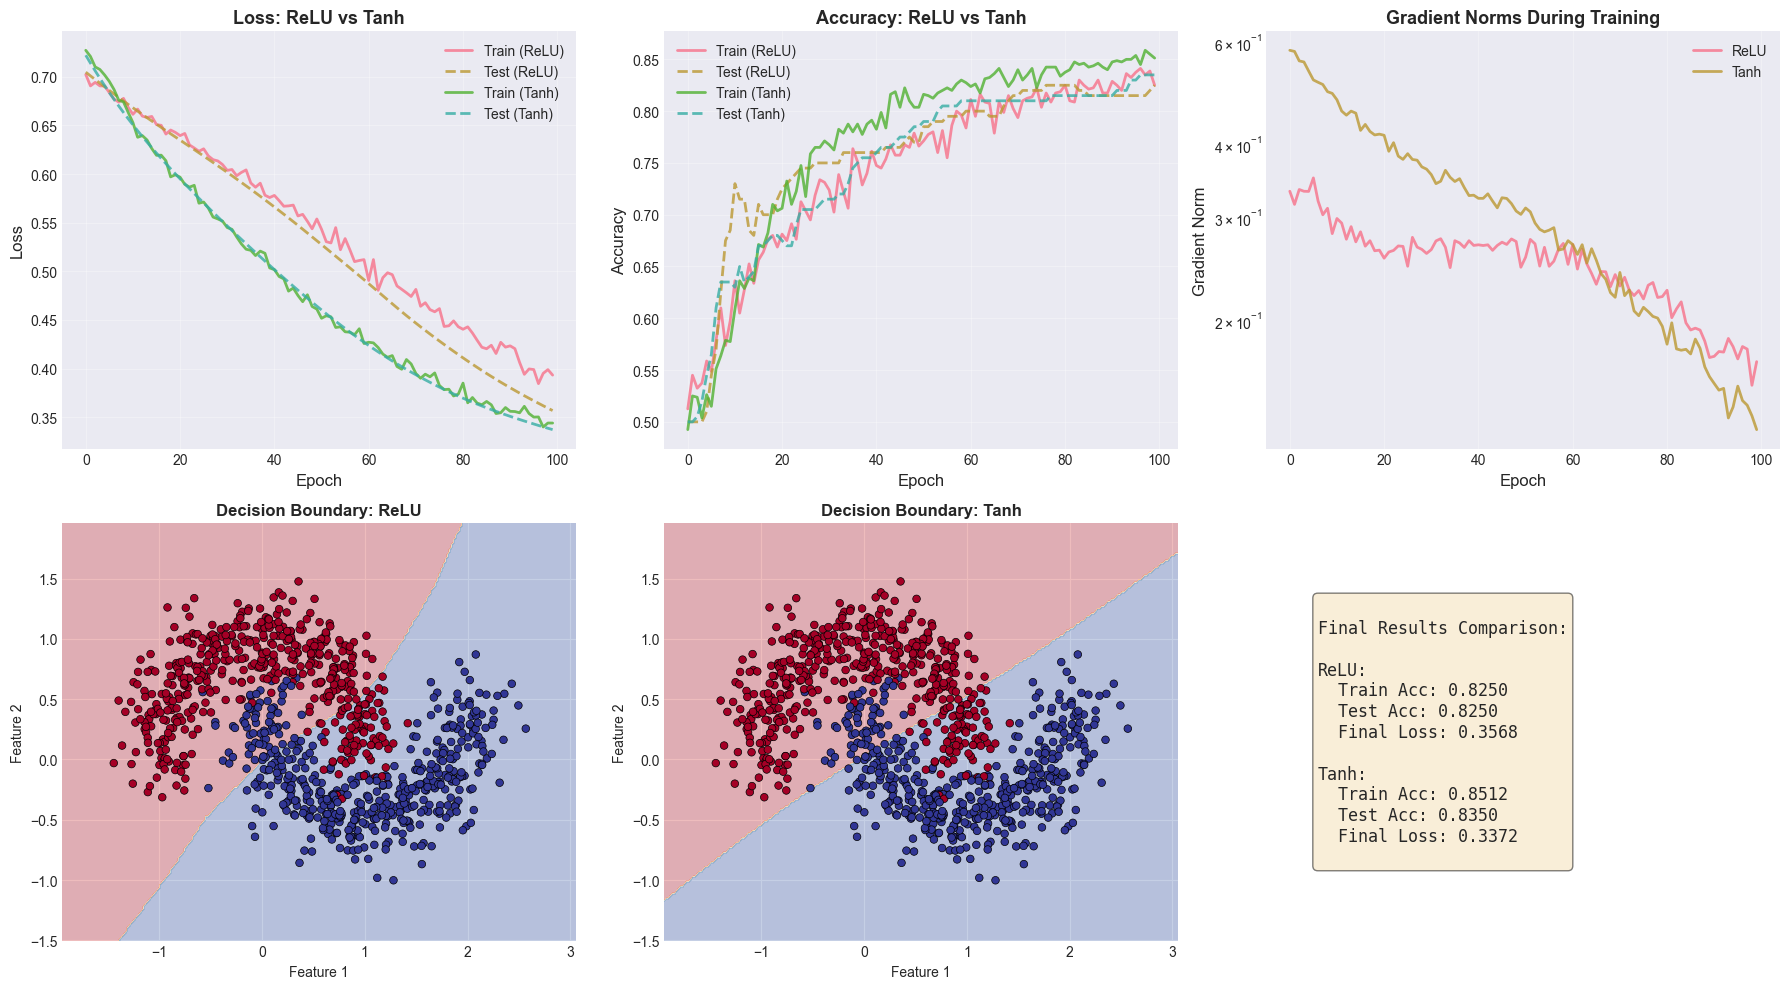

In [48]:
# Comprehensive visualization
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# Loss comparison
axes[0, 0].plot(results_relu['train_losses'], label='Train (ReLU)', linewidth=2, alpha=0.8)
axes[0, 0].plot(results_relu['test_losses'], label='Test (ReLU)', linewidth=2, alpha=0.8, linestyle='--')
axes[0, 0].plot(results_tanh['train_losses'], label='Train (Tanh)', linewidth=2, alpha=0.8)
axes[0, 0].plot(results_tanh['test_losses'], label='Test (Tanh)', linewidth=2, alpha=0.8, linestyle='--')
axes[0, 0].set_xlabel('Epoch', fontsize=12)
axes[0, 0].set_ylabel('Loss', fontsize=12)
axes[0, 0].set_title('Loss: ReLU vs Tanh', fontsize=13, fontweight='bold')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Accuracy comparison
axes[0, 1].plot(results_relu['train_accs'], label='Train (ReLU)', linewidth=2, alpha=0.8)
axes[0, 1].plot(results_relu['test_accs'], label='Test (ReLU)', linewidth=2, alpha=0.8, linestyle='--')
axes[0, 1].plot(results_tanh['train_accs'], label='Train (Tanh)', linewidth=2, alpha=0.8)
axes[0, 1].plot(results_tanh['test_accs'], label='Test (Tanh)', linewidth=2, alpha=0.8, linestyle='--')
axes[0, 1].set_xlabel('Epoch', fontsize=12)
axes[0, 1].set_ylabel('Accuracy', fontsize=12)
axes[0, 1].set_title('Accuracy: ReLU vs Tanh', fontsize=13, fontweight='bold')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Gradient norms
axes[0, 2].plot(results_relu['gradient_norms'], label='ReLU', linewidth=2, alpha=0.8)
axes[0, 2].plot(results_tanh['gradient_norms'], label='Tanh', linewidth=2, alpha=0.8)
axes[0, 2].set_xlabel('Epoch', fontsize=12)
axes[0, 2].set_ylabel('Gradient Norm', fontsize=12)
axes[0, 2].set_title('Gradient Norms During Training', fontsize=13, fontweight='bold')
axes[0, 2].set_yscale('log')
axes[0, 2].legend()
axes[0, 2].grid(True, alpha=0.3)

# Decision boundaries
def plot_db(ax, model, X, y, title):
    """Plot decision boundary for a 2D classification model"""
    model.eval()
    h = 0.02
    
    # Convert to numpy if tensor
    if isinstance(X, torch.Tensor):
        X_np = X.numpy()
    else:
        X_np = np.array(X)
    
    if isinstance(y, torch.Tensor):
        y_np = y.numpy()
    else:
        y_np = np.array(y)
    
    x_min, x_max = X_np[:, 0].min() - 0.5, X_np[:, 0].max() + 0.5
    y_min, y_max = X_np[:, 1].min() - 0.5, X_np[:, 1].max() + 0.5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    mesh_points = torch.FloatTensor(np.c_[xx.ravel(), yy.ravel()])
    with torch.no_grad():
        Z = model(mesh_points)
        Z = torch.argmax(Z, dim=1).numpy()
    Z = Z.reshape(xx.shape)
    ax.contourf(xx, yy, Z, alpha=0.3, cmap=plt.cm.RdYlBu)
    scatter = ax.scatter(X_np[:, 0], X_np[:, 1], c=y_np, cmap=plt.cm.RdYlBu, 
                        edgecolors='black', linewidths=0.5, s=30)
    ax.set_title(title, fontsize=12, fontweight='bold')
    ax.set_xlabel('Feature 1', fontsize=10)
    ax.set_ylabel('Feature 2', fontsize=10)

plot_db(axes[1, 0], model_relu, X_complex, y_complex, 'Decision Boundary: ReLU')
plot_db(axes[1, 1], model_tanh, X_complex, y_complex, 'Decision Boundary: Tanh')

# Final comparison
axes[1, 2].axis('off')
comparison_text = f"""
Final Results Comparison:

ReLU:
  Train Acc: {results_relu['train_accs'][-1]:.4f}
  Test Acc: {results_relu['test_accs'][-1]:.4f}
  Final Loss: {results_relu['test_losses'][-1]:.4f}

Tanh:
  Train Acc: {results_tanh['train_accs'][-1]:.4f}
  Test Acc: {results_tanh['test_accs'][-1]:.4f}
  Final Loss: {results_tanh['test_losses'][-1]:.4f}
"""
axes[1, 2].text(0.1, 0.5, comparison_text, fontsize=12, 
                verticalalignment='center', family='monospace',
                bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.show()


---

## Summary: Key Takeaways

### 1. **Perceptron → Neural Network**
- **Single perceptron**: Can only learn linearly separable problems (e.g., AND gate)
- **Multiple layers**: Enable non-linear decision boundaries (e.g., XOR problem)
- **Hidden layers**: Transform input through multiple non-linear transformations
- **Key insight**: Stacking linear layers with non-linear activations creates powerful function approximators

### 2. **Activation Functions**
- **ReLU**: Default choice for hidden layers - fast, simple, helps with vanishing gradients
- **Tanh**: Zero-centered alternative - good for RNNs, bounded outputs
- **Sigmoid**: Classic choice for output layers in binary classification
- **Key insight**: Non-linearity is essential - without it, multiple layers collapse to one

### 3. **Backpropagation - The Learning Engine**
- **Chain rule**: Applied layer by layer to compute gradients
- **PyTorch magic**: `loss.backward()` automatically computes all gradients
- **Critical step**: Always call `optimizer.zero_grad()` before backward pass!
- **Key insight**: Gradients flow backward, telling each weight how to change to reduce loss

### 4. **Training Loop - The Foundation**
```python
for epoch in range(num_epochs):
    model.train()  # Set training mode
    
    # Forward pass
    outputs = model(inputs)
    loss = criterion(outputs, targets)
    
    # Backward pass
    optimizer.zero_grad()  # Clear previous gradients (CRITICAL!)
    loss.backward()        # Compute gradients via backpropagation
    optimizer.step()       # Update weights using gradients
    
    # Evaluation
    model.eval()  # Set evaluation mode
    with torch.no_grad():  # No gradients needed
        test_outputs = model(test_inputs)
        test_loss = criterion(test_outputs, test_targets)
```

### 5. **Optimizers - How We Update Weights**
- **SGD**: Simple, stable, good baseline - fixed learning rate for all parameters
- **SGD + Momentum**: Faster convergence - accumulates gradient history like a rolling ball
- **RMSProp**: Adaptive learning rates - adjusts step size per parameter based on gradient magnitude
- **Adam**: Best of both worlds - combines momentum + adaptive learning rates
- **Key insight**: Different optimizers suit different problems - Adam is often a good default, but SGD can generalize better

### 6. **Regularization - Preventing Overfitting**
- **Dropout**: Randomly disable neurons during training (typically 0.2-0.5 probability)
- **Effect**: Forces network to be robust, prevents over-reliance on specific neurons
- **Important**: Only active during training - all neurons used during inference!
- **Key insight**: If train accuracy >> test accuracy, you're overfitting - use dropout or other regularization

### 7. **Debugging Tools - Understanding Your Network**
- **Weight inspection**: Check if weights are too large/small (initialization matters!)
- **Gradient inspection**: Detect vanishing (too small) or exploding (too large) gradients
- **Activation inspection**: Detect dying ReLU problem (too many zeros)
- **Loss curves**: Monitor train vs test loss to detect overfitting
- **Key insight**: Healthy networks have stable gradient norms and reasonable weight distributions

### 8. **Best Practices**
1. **Always set random seeds** for reproducibility
2. **Use `model.train()` and `model.eval()`** to toggle training/evaluation modes
3. **Use `torch.no_grad()`** during evaluation to save memory
4. **Monitor both train and test metrics** to detect overfitting
5. **Start simple** - add complexity only when needed
6. **Visualize** - plots help understand what's happening

### Common Pitfalls to Avoid
- ❌ Forgetting `optimizer.zero_grad()` → gradients accumulate incorrectly
- ❌ Using `model.train()` during evaluation → dropout active during inference
- ❌ Not monitoring test set → can't detect overfitting
- ❌ Using wrong learning rate → too high (unstable) or too low (slow convergence)
- ❌ Ignoring gradient norms → missing vanishing/exploding gradient problems

### Next Steps for Deep Learning
- **Batch Normalization**: Normalize activations to stabilize training
- **Learning Rate Scheduling**: Adjust learning rate during training
- **Weight Initialization**: Better initialization strategies (Xavier, He)
- **Advanced Architectures**: Convolutional Neural Networks (CNNs) for images
- **Recurrent Networks**: LSTM/GRU for sequential data
- **Transfer Learning**: Using pre-trained models
- **Hyperparameter Tuning**: Systematic search for best hyperparameters

### Resources for Further Learning
- **PyTorch Documentation**: https://pytorch.org/docs/
- **Deep Learning Book** (Goodfellow et al.): Comprehensive theory
- **Fast.ai**: Practical deep learning course
- **Papers with Code**: Latest research implementations

**Remember**: Understanding the fundamentals (backpropagation, training loops, optimizers) is more valuable than memorizing architectures. Build intuition, experiment, and learn from your mistakes!

**Happy Learning! 🚀**
